In [ ]:
import os
from textwrap import wrap
from typing import List

import pandas as pd
import numpy as np
from IPython.display import display
from joblib import Parallel, delayed, dump

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm 

In [ ]:
def readRecord(path, id):
    recordFileName = os.path.join(path, 'records', f'record-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readFeature(path, id):
    recordFileName = os.path.join(path, 'features', f'feature-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readRecords(path, serverNum):
    recordList = [readRecord(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def readFeatures(path, serverNum):
    recordList = [readFeature(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def dropWarmUpIdx(df, warmupDrop):
    # Drop warm up rows
    warmupDropTimestamp = df.loc[1, 'Start time'] + warmupDrop
    print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    keepIndices = df['Start time'] > warmupDropTimestamp
    return warmupDropTimestamp, keepIndices

def genSampleIdx(rowNum, sample):
    dropIndices = []
    if sample != None:
        removeN = rowNum - sample
        if removeN > 0:
            np.random.seed(55)
            dropIndices = np.random.choice(rowNum, removeN, replace=False)
    return dropIndices

def union(lst1, lst2):
    if len(lst1) == 0:
        final_list = lst2
    elif len(lst2) == 0:
        final_list = lst1
    else:
        final_list = lst1 + lst2
    return final_list

def dropOutliners(series, r):
    meanC = np.mean(series)
    stdC = np.std(series)

    # Drop rows that out of 'r' times of standard deviation
    indice = ((series < meanC + r * stdC) & (series > meanC - r * stdC))
    return indice

def histogram(series, targetName, unit, figPath='', isSaveFig=False, state='', info=''):
    # Show histogram of the latency
    if unit == 'nano':
        # Nanosec
        series = series.to_numpy()
        nBins = np.unique(series)
        unit_str = 'nanosec'
    elif unit == 'micro':
        # Microsec
        series = np.round(series.to_numpy() / 1000, decimals=0)
        nBins = np.unique(series)
        unit_str = 'microsec'
    else: 
        raise BaseException(f'No such unit: {unit}')

    # maxNBins = 1000
    # nBins = np.reshape(np.unique(series), (-1)).shape[0]
    # if nBins > maxNBins:
    #     nBins = maxNBins
    
    # Show mean and std
    print(f'In {unit_str}, Number of bins: {nBins.shape[0]}')
    meanL = np.round(np.mean(series), 2)
    stdL = np.round(np.std(series), 2)
    print(f'Mean Latency: {meanL}, Std Latency: {stdL} ({unit_str})')
    infos = "\n".join(wrap(f"Mean: {meanL}, Std: {stdL} (in {unit_str})"))
    # Density
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, label='PMF')
    # plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Histogram of {targetName}, {infos} | {info}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'hist_{unit_str}_{state}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

    # Cumulative
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Distribution of {targetName}, {infos} | {info}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'cdf_{unit_str}_{state}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def prepareData(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                featureNames: List[str], targetName: str, figPath: str,
                warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                histUnit: str="micro", dataUnit: str="micro", isSaveFig: bool=False, isSC: bool=False):

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_df_drop = feature_df.loc[keepIndices, :]
        target_df_drop = target_df.loc[keepIndices, :]
    else:
        feature_df_drop = feature_df
        target_df_drop = target_df

    # Drop outliners
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_df_drop[targetName], r=outlinerDrop)
        feature_df_drop = feature_df_drop.loc[outlinersIndice, :]
        target_df_drop = target_df_drop.loc[outlinersIndice, :]

    # Select features
    features = feature_df_drop[featureNames].reset_index(drop=True)
    # features = feature_df_drop.reset_index(drop=True)
    # features = feature_df_drop.drop(['Transaction ID', 'Start time'], axis=1).reset_index(drop=True)
    targets = target_df_drop[targetName].reset_index(drop=True)

    # Random draw samples
    dropIndices = genSampleIdx(rowNum=features.shape[0], sample=sample)
    features = features.drop(dropIndices).reset_index(drop=True)
    targets = targets.drop(dropIndices).reset_index(drop=True)

    # Draw histogram of the target latency
    histogram(targets, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig)
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def prepareDataModified(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                        featureNames: List[str], targetName: str, figPath: str,
                        warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                        histUnit: str="micro", dataUnit: str="micro", isSaveFig: bool=False, isSC: bool=False):

    # Select features
    features_sel = feature_df[featureNames]
    targets_sel = target_df[[targetName]]

    state = ''
    info = 'Remain - '
    # Draw histogram of the target latency
    histogram(targets_sel, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state='original')

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_warmup = features_sel.loc[keepIndices, :].reset_index(drop=True)
        target_warmup = targets_sel.loc[keepIndices, :].reset_index(drop=True)
        # Draw histogram of the target latency
        state = f'w-warmup'
        info = f'{info} Warmup: {np.round(target_warmup.shape[0] * 100 / targets_sel.shape[0], 2)}%'
        histogram(target_warmup, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state=state, info=info)
    else:
        feature_warmup = features_sel
        target_warmup = targets_sel

    print(f"feature_warmup shape: {feature_warmup.shape}")
    display(feature_warmup)
    print(f"target_warmup shape: {target_warmup.shape}")
    display(target_warmup)

    # Drop outliners
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_warmup[targetName], r=outlinerDrop)
        print(outlinersIndice.shape)

        feature_outliner = feature_warmup.loc[outlinersIndice, :].reset_index(drop=True)
        print(f"feature_outliner shape: {feature_outliner.shape}")
        target_outliner = target_warmup.loc[outlinersIndice, :].reset_index(drop=True)
        print(f"target_outliner shape: {target_outliner.shape}")

        # Draw histogram of the target latency
        state = f'{state}_wo-ouliner'
        info = f'{info} Outliner: {np.round(target_outliner.shape[0] * 100 / targets_sel.shape[0], 2)}%'
        histogram(target_outliner, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state=state, info=info)
    else:
        feature_outliner = feature_warmup
        target_outliner = target_warmup

    # Random draw samples
    if sample != None:
        dropIndices = genSampleIdx(rowNum=feature_outliner.shape[0], sample=sample)
        features = feature_outliner.drop(dropIndices).reset_index(drop=True)
        targets = target_outliner.drop(dropIndices).reset_index(drop=True)

        # Draw histogram of the target latency
        state = f'{state}_w-sample'
        info = f'{info} Sample: {np.round(targets.shape[0] * 100 / targets_sel.shape[0], 2)}%'
        histogram(targets, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig, state=state, info=info)
    else:
        features = feature_outliner
        targets = target_outliner
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def plot(X_test, y_test, y_pred, figPath='', name='', infos='', isSaveFig=False):
    unit_str = 'nanosec'
    fig = figure(figsize=(16, 9), dpi=120)
    sc = plt.scatter(y_test, y_pred)

    plt.xlabel(f"True Latency (in {unit_str})")
    plt.ylabel(f"Predict Latency (in {unit_str})")
    plt.title(f'{name} Latency Prediction during benchmark (in {unit_str}) {infos}')

    plt.axline((0, 0), (1, 1), color="black", linestyle=(0, (5, 5)))

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under path
    if isSaveFig:
        figFileName = os.path.join(figPath, f'fit_{name}_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def boxPlot(data, positions, showfliers):
    fig = figure(figsize=(16, 9), dpi=120)
    
    plt.boxplot(data, positions=positions, showfliers=showfliers)

def fitModel(model, X_train, X_test, y_train, y_test, figPath='', modelPath='', name='', isSaveFig=False, isSaveModel=False):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy().ravel()
    y_test_np = y_test.to_numpy().ravel()

    # Fir on training data
    model.fit(X_train_np, y_train_np)

    # Test on testing dataset
    score = model.score(X_test_np, y_test_np)
    y_pred = model.predict(X_test_np)

    # Compute score
    trainScore = np.round(-model.best_score_, 4)
    testScore = np.round(-score, 4)
    params = model.best_params_
    print(f'Best training/testing score: {trainScore}/{testScore}')
    print(f'Best Params: {params}')
    
    infos = f"\n relative error on train/test dataset: {trainScore}/{testScore} \n params: {params}"

    plot(X_test_np, y_test_np, y_pred, figPath=figPath, name=name, infos=infos, isSaveFig=isSaveFig)

    # Save model under path
    if isSaveModel:
        modelName = os.path.join(modelPath, f'{name}.joblib')    
        s = dump(model, modelName)
    return model, trainScore, testScore

def modelSearch(model, X_train, X_test, y_train, y_test, name, params, figPath, modelPath, isSaveFig, isSaveModel, n_jobs=-1):
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=n_jobs, verbose=2)
    bestModel, trainScore, testScore = fitModel(gs, X_train, X_test, y_train, y_test, figPath=figPath, modelPath=modelPath, name=name, isSaveFig=isSaveFig, isSaveModel=isSaveModel)

    return bestModel, trainScore, testScore

def makePath(path: str, dirName: str):
    dirPath = os.path.join(path, dirName)
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

    return dirPath

In [ ]:
class RegressionTask:
    def __init__(self, modelDirName, figDirName, serverNum, warmupDrop, sampleN, outlinerDropR, histUnit, isSC, testSize, isSaveFig, isSaveModel, randomState):
        # Path & Directory options
        self.path = None
        self.modelDirName = modelDirName
        self.figDirName = figDirName
        # Create path
        self.figPath = None
        self.modelPath = None

        self.serverNum = serverNum
        self.warmupDrop = warmupDrop
        self.sampleN = sampleN
        self.outlinerDropR = outlinerDropR
        self.histUnit = histUnit
        self.isSC = isSC
        self.testSize = testSize
        self.isSaveFig = isSaveFig
        self.isSaveModel = isSaveModel
        self.randomState = randomState
    
    def setPath(self, path):
        # Path & Directory options
        self.path = path
        # Create path
        self.figPath = makePath(path, figDirName)
        self.modelPath = makePath(path, modelDirName)        

    def buildDataset(self):
        if (self.path == None) or (self.figPath == None) or (self.modelPath == None):
            raise BaseException('self.path, self.figPath, or self.modelPath is None, please call setPath() method at first.')
        self.records = readRecords(self.path, self.serverNum)
        print(f'Records: Time of Each Component with shape: {self.records.shape}')
        display(self.records)

        self.features = readFeatures(self.path, self.serverNum)
        print(f'Features: Features with shape: {self.features.shape}')
        display(self.features)
        
    def drawBoxPlot(self, featureName: str, targetName: str, showfliers: bool):
        features = np.round(self.features[featureName])
        targets = np.round(self.records[targetName] / 1000)

        uniqueFeats = np.unique(features)
        data = []
        for feat in uniqueFeats:
            indice = (features == feat)
            data.append(targets[indice])

        boxPlot(data=data, positions=uniqueFeats.tolist(), showfliers=showfliers)

    def buildModelList(self, modelList: List):
        self.modelList = modelList

    def fit(self, featureNames: List, targetName: str, n_jobs: int):
        # Create path for OU
        figPathOU = makePath(self.figPath, targetName)
        modelPathOU = makePath(self.modelPath, targetName)

        # Prepare Data
        # OUFeatures, OUTargets = prepareData(self.features, self.records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
        #                                     warmupDrop=self.warmupDrop, outlinerDrop=self.outlinerDropR, sample=self.sampleN, histUnit=self.histUnit, isSaveFig=self.isSaveFig, isSC=self.isSC)
        OUFeatures, OUTargets = prepareDataModified(self.features, self.records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                                    warmupDrop=self.warmupDrop, outlinerDrop=self.outlinerDropR, sample=self.sampleN, histUnit=self.histUnit, isSaveFig=self.isSaveFig, isSC=self.isSC)
        print(f'OU - {targetName} Features shape: {OUFeatures.shape}')
        display(OUFeatures)
        print(f'OU - {targetName} Targets shape: {OUTargets.shape}')
        display(OUTargets)

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(OUFeatures, OUTargets, test_size=self.testSize, random_state=self.randomState)

        # Fit Model
        results = Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                                          figPath=figPathOU, modelPath=modelPathOU, 
                                                          isSaveFig=self.isSaveFig, isSaveModel=self.isSaveModel, 
                                                          n_jobs=n_jobs) for m in self.modelList)
        return results

In [ ]:
# Path Options
# path = 'ous/REC100_RW0'
modelDirName = 'model'
figDirName = 'img'

# Dataset options
serverNum = 1
# warmupDrop = 90000000
warmupDrop = 0
# sampleN = 10000
sampleN = None
outlinerDropR = 1
histUnit = 'micro'
isSC = False
testSize = 0.2
n_jobs = -1

# Save Options
isSaveFig = True
isSaveModel = False

# Random Seed
randomState = 42

# Create RegressionTask
rt = RegressionTask(modelDirName=modelDirName, figDirName=figDirName,
                    serverNum=serverNum, warmupDrop=warmupDrop, sampleN=sampleN, outlinerDropR=outlinerDropR, 
                    histUnit=histUnit, isSC=isSC, testSize=testSize,
                    isSaveFig=isSaveFig, isSaveModel=isSaveModel, randomState=randomState)

# Model Parameters List

In [ ]:
krr = {
        'name': 'KRR',
        'model': KernelRidge(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'alpha': [1.0]
        }
    }
svr = {
        'name': 'SVR',
        'model': SVR(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'C': [0, 0.5, 1.0, 2.0, 4.0]
        }
    }
hr = {
        'name': 'HR',
        'model': HuberRegressor(),
        'param': {
            'epsilon': [1.1, 1.35, 2, 5],
            'alpha': [0, 0.0001, 0.01, 0.1, 1]
        }
    }
rfr = {
        'name': 'RFR',
        'model': RandomForestRegressor(),
        'param': {
            'n_estimators': [50, 100, 500],
            'criterion': ['mse', 'mae'],
            'max_depth': [3, 5, 7, 10],
            'random_state': [0],
            'n_jobs': [None]
        }
    }
modelList = [hr, rfr]

rt.buildModelList(modelList=modelList)

# Features & Tragets List

In [ ]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
# Prediction Targets
targetNames = ['Tx commit', 'Flush', '(Master) Execute SQL', 'Generate plan', 'Init thread']

# Training Dataset
paths = ['ous/REC2_RW0', 'ous/REC2_RW1', 'ous/REC2_RW05'] 
        #  'ous/REC10_RW0', 'ous/REC10_RW1', 'ous/REC10_RW05',
        #  'ous/REC100_RW0', 'ous/REC100_RW1', 'ous/REC100_RW05'
        # ]

In [ ]:
for path in paths:
    rt.setPath(path=path)
    rt.buildDataset()
    for targetName in targetNames:
        rt.drawBoxPlot(featureName=featureNames, targetName=targetName, showfliers=False)
        # rt.fit(featureNames=featureNames, targetName=targetName, n_jobs=n_jobs)

Records: Time of Each Component with shape: (116400, 17)


Transaction ID  Execution Time  Txn Start TimeStamp  Generate plan  \
0                    1       189237579     2413350991624338        2785219   
1                    2         5862485     2413351268257418         307820   
2                    3         5650785     2413351278423903         164957   
3                    4         4323154     2413351288336560         148439   
4                    5         3774862     2413351297104623         123421   
...                ...             ...                  ...            ...   
116395          116396          491806     2413650920521590         143870   
116396          116397          459978     2413650922585052         111760   
116397          116398          474337     2413650925567087         122861   
116398          116399          474534     2413650927809914         114799   
116399          116400          480807     2413650930013241         152421   

        Init thread  Average Time Of Read-Only Txn  Get locks  \
0            447779                      180874366      71759   
1            495598                        4633718      48042   
2            553509                        4693742      48734   
3            511675                        3492113      28249   
4            486009                        2995772      57205   
...             ...                            ...        ...   
116395        31103                         292302       4678   
116396        31041                         293478       4175   
116397        41052                         286059       3831   
116398        40567                         294860       3446   
116399        14298                         292305       3422   

        (Master) Read from local storage  (Master) Read from remote  \
0                              180609965                      13731   
1                                4368911                       3132   
2                                2960623                       3360   
3                                3198106                       2929   
4                                2699227                       3933   
...                                  ...                        ...   
116395                            279379                        602   
116396                            281274                        636   
116397                            274370                        510   
116398                            283177                        487   
116399                            281168                        592   

        (Master) Execute SQL  (Master) Push  Flush  Tx commit  Release Lock  \
0                      40925           3094  47659      59868         44393   
1                      11932            592   6899     186238        174380   
2                      11994            600   7664    1651620       1636150   
3                      11593            722   7690     234159        221232   
4                      15109            768   8163     201914        187307   
...                      ...            ...    ...        ...           ...   
116395                  1314             65    513       4588          2445   
116396                  1507             71    472       4134          2297   
116397                  1259             62    521       4065          2168   
116398                  1394             63    632       4306          2321   
116399                  1293             56    521       4040          2200   

        Unpin  Txn End TimeStamp  Average Time Of R/W Txn  
0        4317   2413351176951099                        0  
1        3733   2413351273134310                        0  
2        5170   2413351283214776                        0  
3        4144   2413351291915098                        0  
4        5146   2413351300189895                        0  
...       ...                ...                      ...  
116395    464   2413650920835317                        0  
116396  

Features: Features with shape: (116400, 16)


Transaction ID    Start time  Num of reads  Num of writes  \
0                    1             0            10              0   
1                    2     279562672            10              0   
2                    3     289854925            10              0   
3                    4     299883018            10              0   
4                    5     308705806            10              0   
...                ...           ...           ...            ...   
116395          116396  299932635388            10              0   
116396          116397  299934730941            10              0   
116397          116398  299937691901            10              0   
116398          116399  299939943339            10              0   
116399          116400  299942134907            10              0   

        Num of active txs  Thread pool size  CPU utilization  \
0                       1                50              0.0   
1                       1                50              0.0   
2                       1                50              1.0   
3                       1                50              3.0   
4                       1                50              2.0   
...                   ...               ...              ...   
116395                  1                50              0.0   
116396                  1                50              0.0   
116397                  1                50              3.0   
116398                  1                50              0.0   
116399                  1                50              0.0   

        Num of cache read  Num of cache insert  Num of cache update  \
0                      20                    0                    0   
1                      20                    0                    0   
2                      20                    0                    0   
3                      20                    0                    0   
4                      20                    0                    0   
...                   ...                  ...                  ...   
116395                 20                    0                    0   
116396                 20                    0                    0   
116397                 20                    0                    0   
116398                 20                    0                    0   
116399                 20                    0                    0   

        Num of arithmetic operations  Num of write record  Num of bytes  \
0                                  0                    0             0   
1                                  0                    0             0   
2                                  0                    0             0   
3                                  0                    0             0   
4                                  0                    0             0   
...                              ...                  ...           ...   
116395                             0                    0             0   
116396                             0                    0             0   
116397                             0                    0             0   
116398                             0                    0             0   
116399                             0                    0             0   

        Num of read write record  Num of log flush bytes  Num of Threads  
0                             10                       0              22  
1                             10                       0              25  
2                             10                       0              26  
3                             10                       0              27  
4                             10                       0              28  
...                          ...                     ...             ...  
116395                        10                       0              67  
116396                        10                       0

Warm Up Drop Timestamp: 369562672
In microsec, Number of bins: 7, nBins: [3. 4. 5. 6. 7. 8. 9.]
Mean Latency: 4.43, Std Latency: 0.89 (microsec)


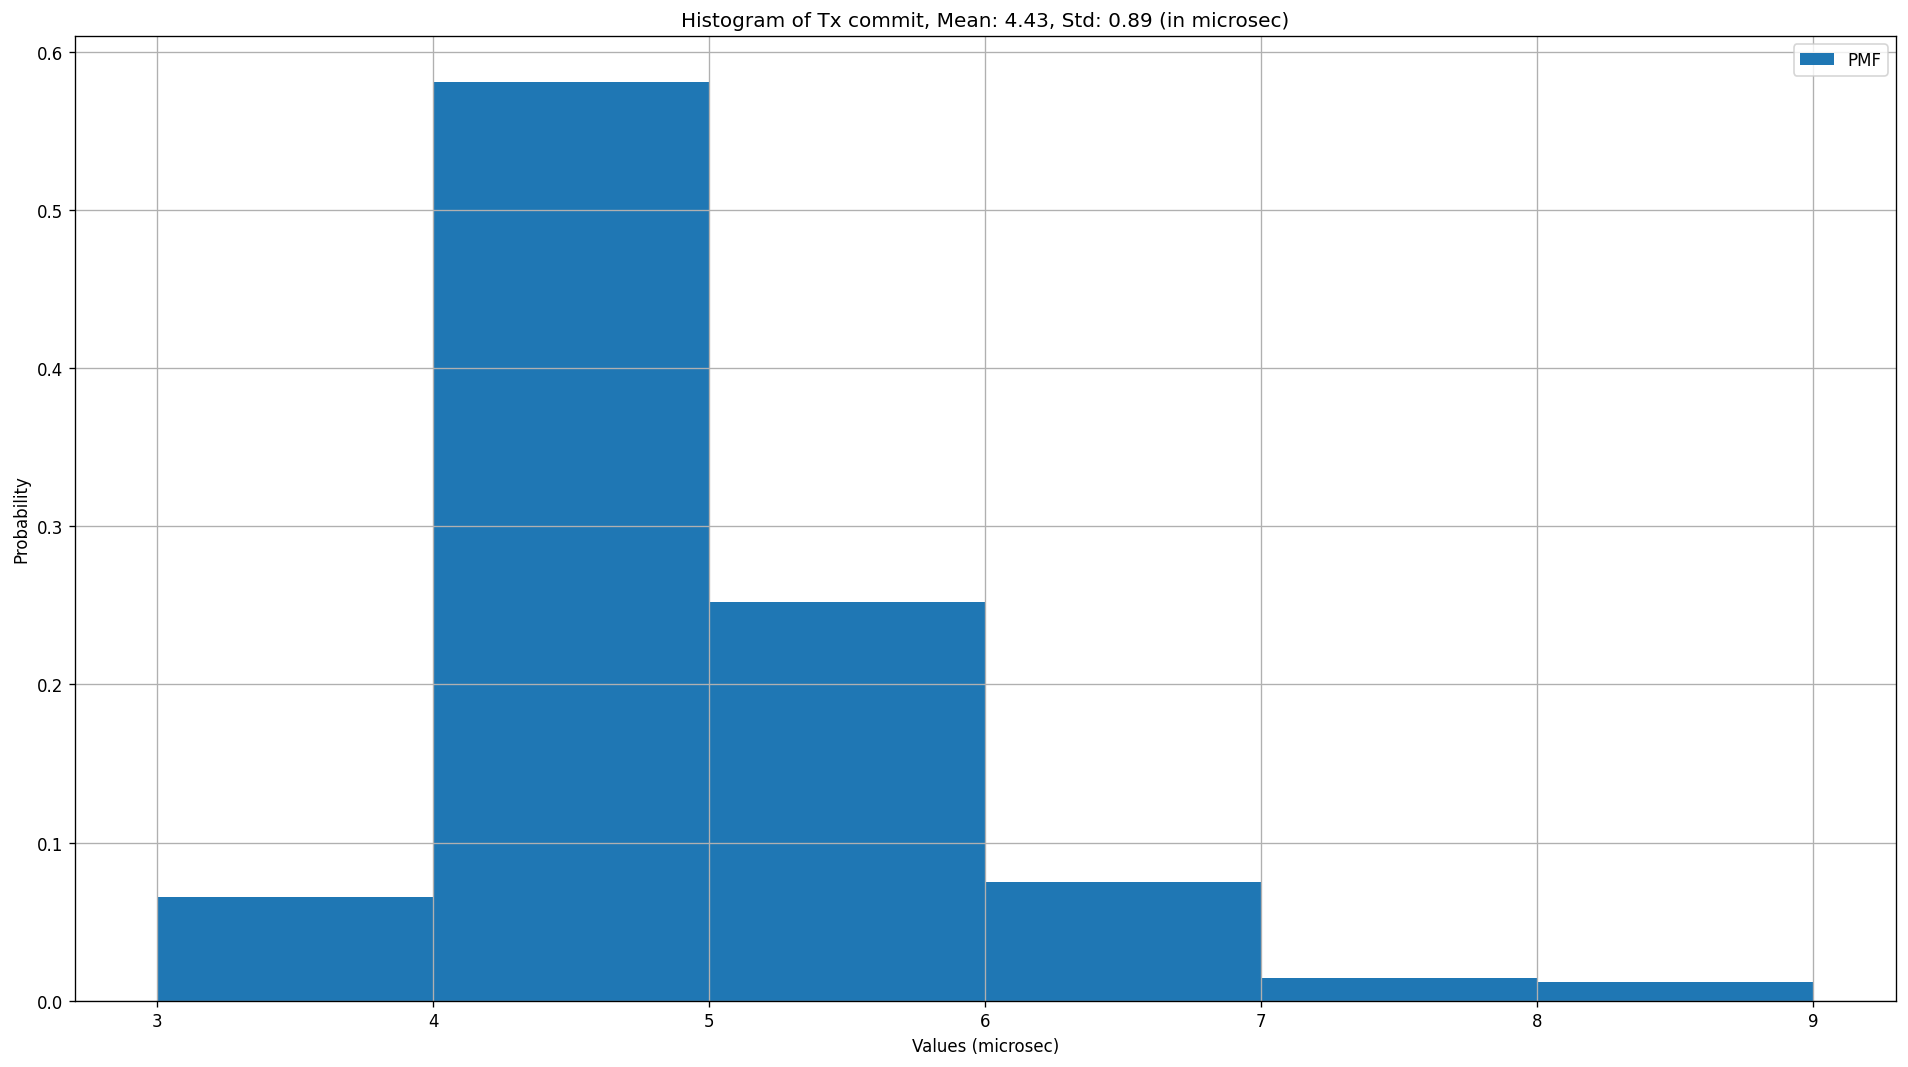

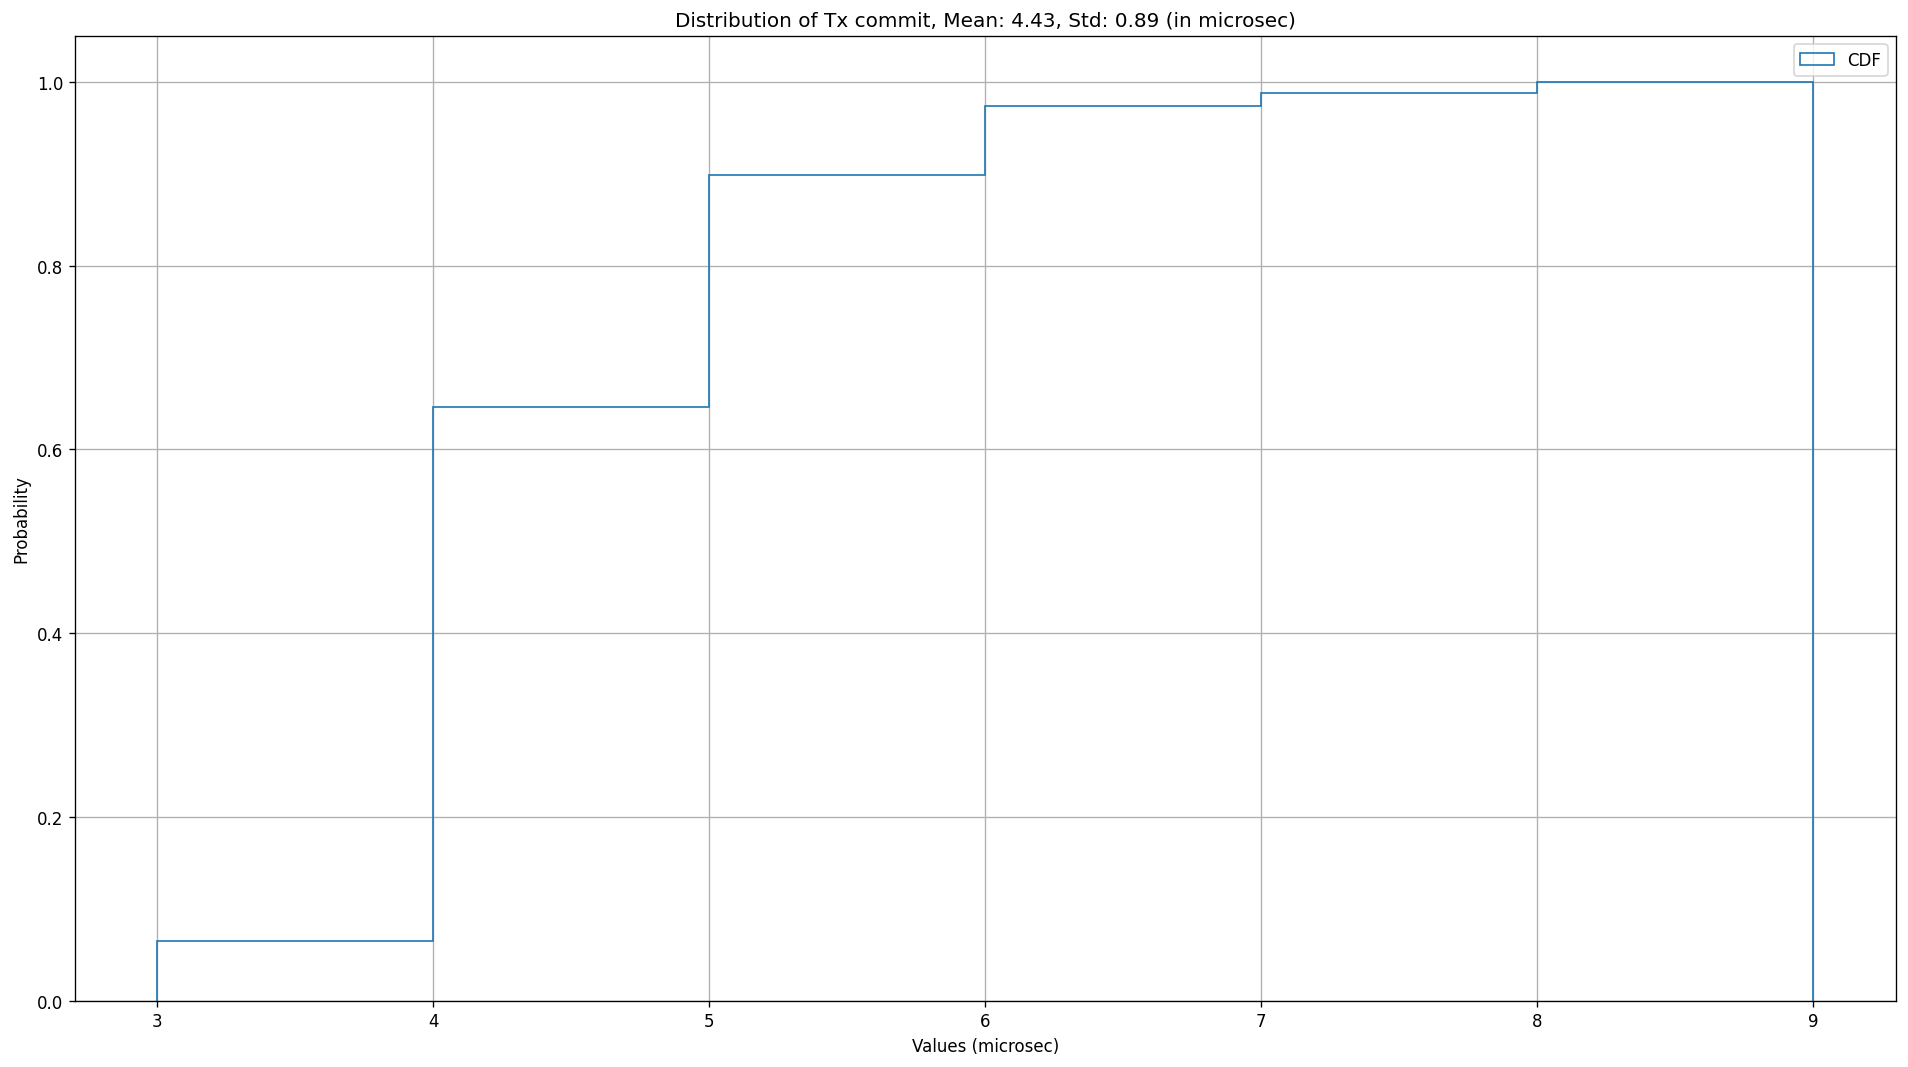

OU - Tx commit Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0               10              0                  1                50   
1               10              0                  1                50   
2               10              0                  1                50   
3               10              0                  1                50   
4               10              0                  1                50   
...            ...            ...                ...               ...   
9995            10              0                  1                50   
9996            10              0                  1                50   
9997            10              0                  1                50   
9998            10              0                  1                50   
9999            10              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 3.0                 20                    0   
1                 4.0                 20                    0   
2                 3.0                 20                    0   
3                 3.0                 20                    0   
4                 4.0                 20                    0   
...               ...                ...                  ...   
9995              0.0                 20                    0   
9996              4.0                 20                    0   
9997              4.0                 20                    0   
9998              4.0                 20                    0   
9999              0.0                 20                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                        10                       0   
1                0                        10                       0   
2                0                        10                       0   
3                0                        10                       0   
4                0                        10                       0   
...            ...                       ...                     ...   
9995             0                        10                       0   
9996             0                        10                       0   
9997             0                        10                       0   
9998             0                        10                       0   
9999             0                        10                       0   

      Num of Threads  
0                 67  
1                 67  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU - Tx commit Targets shape: (10000,)


0       8959
1       7209
2       8673
3       8159
4       8245
        ... 
9995    4625
9996    4128
9997    4598
9998    3874
9999    4207
Name: Tx commit, Length: 10000, dtype: int64

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.107/0.1099
Best Params: {'alpha': 1.0, 'gamma': 0.5, 'kernel': 'rbf'}


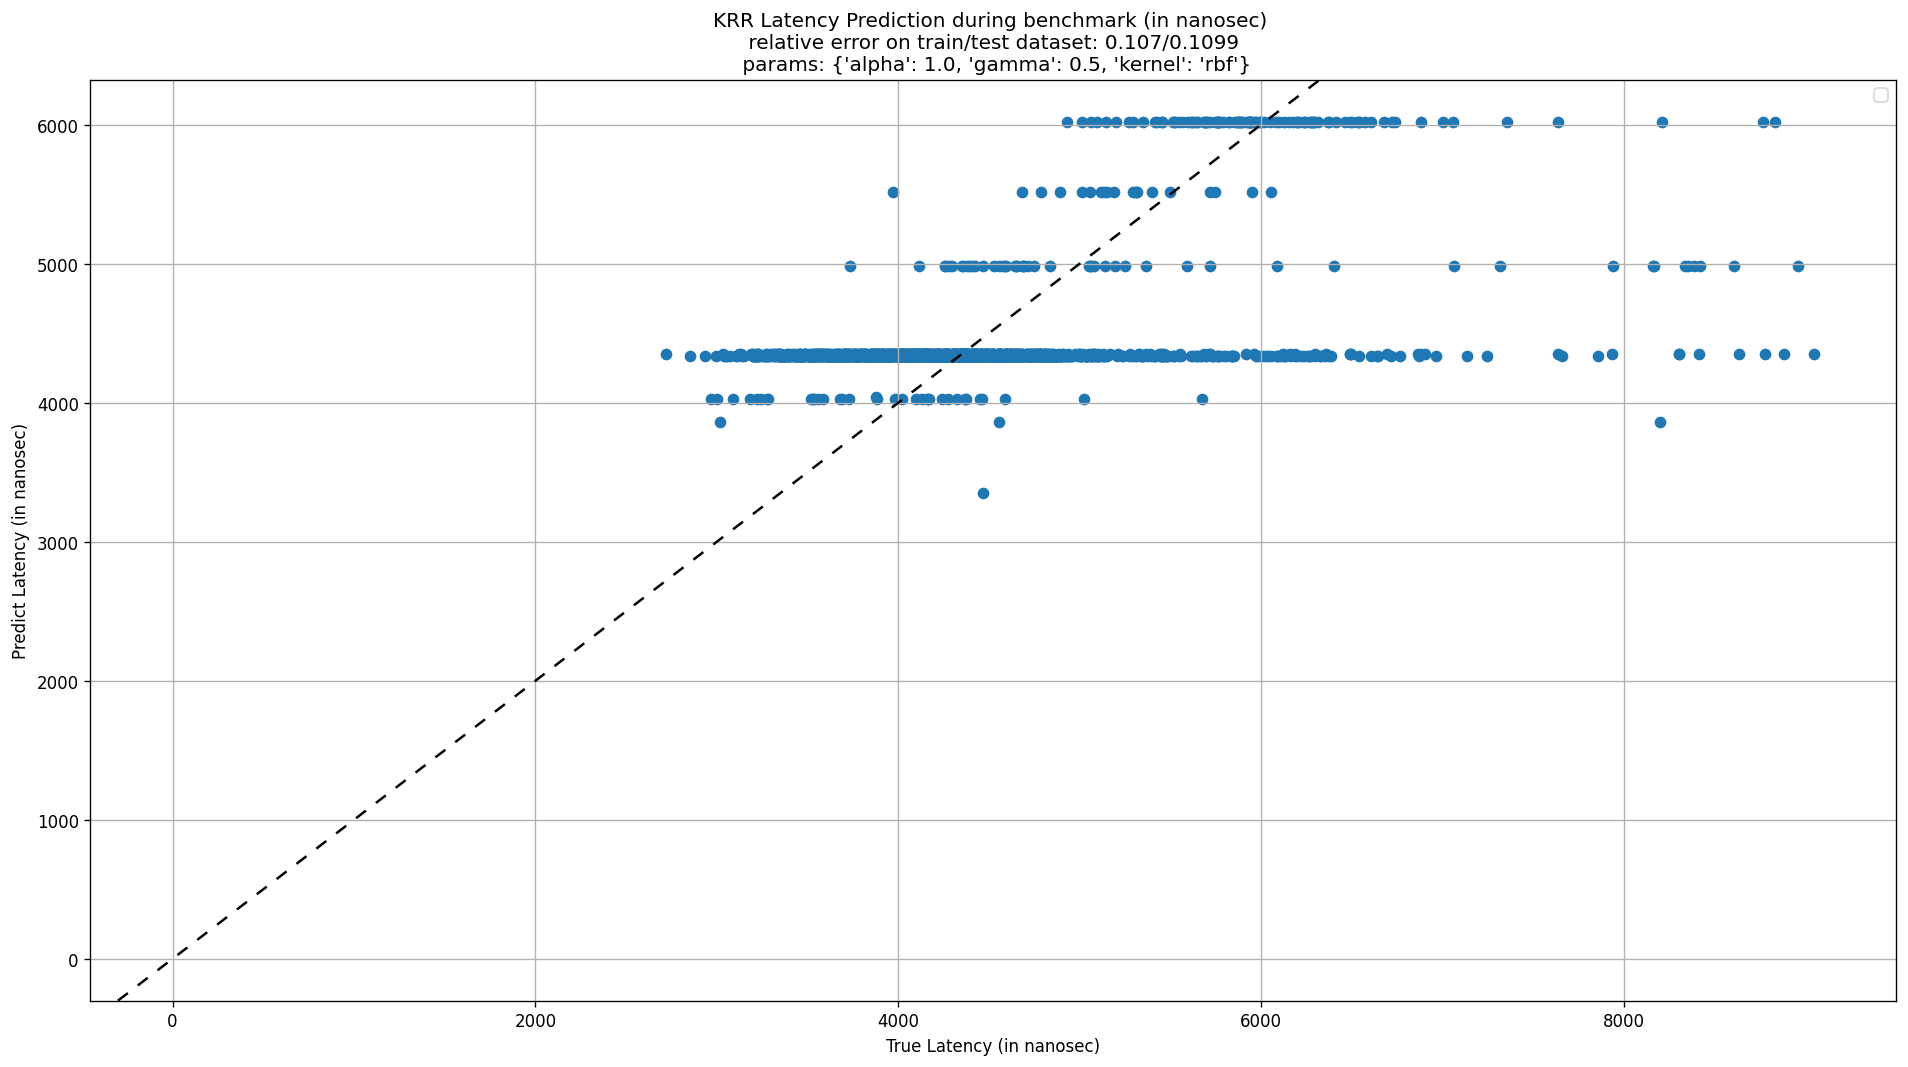

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.11689716 -0.11589454
 -0.11551115 -0.11523674 -0.11644735 -0.11456799 -0.11383425 -0.11335875
 -0.1156476  -0.11230909 -0.11092487 -0.11014905 -0.11433043 -0.10908528
 -0.10733992 -0.10673977]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1067/0.1088
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


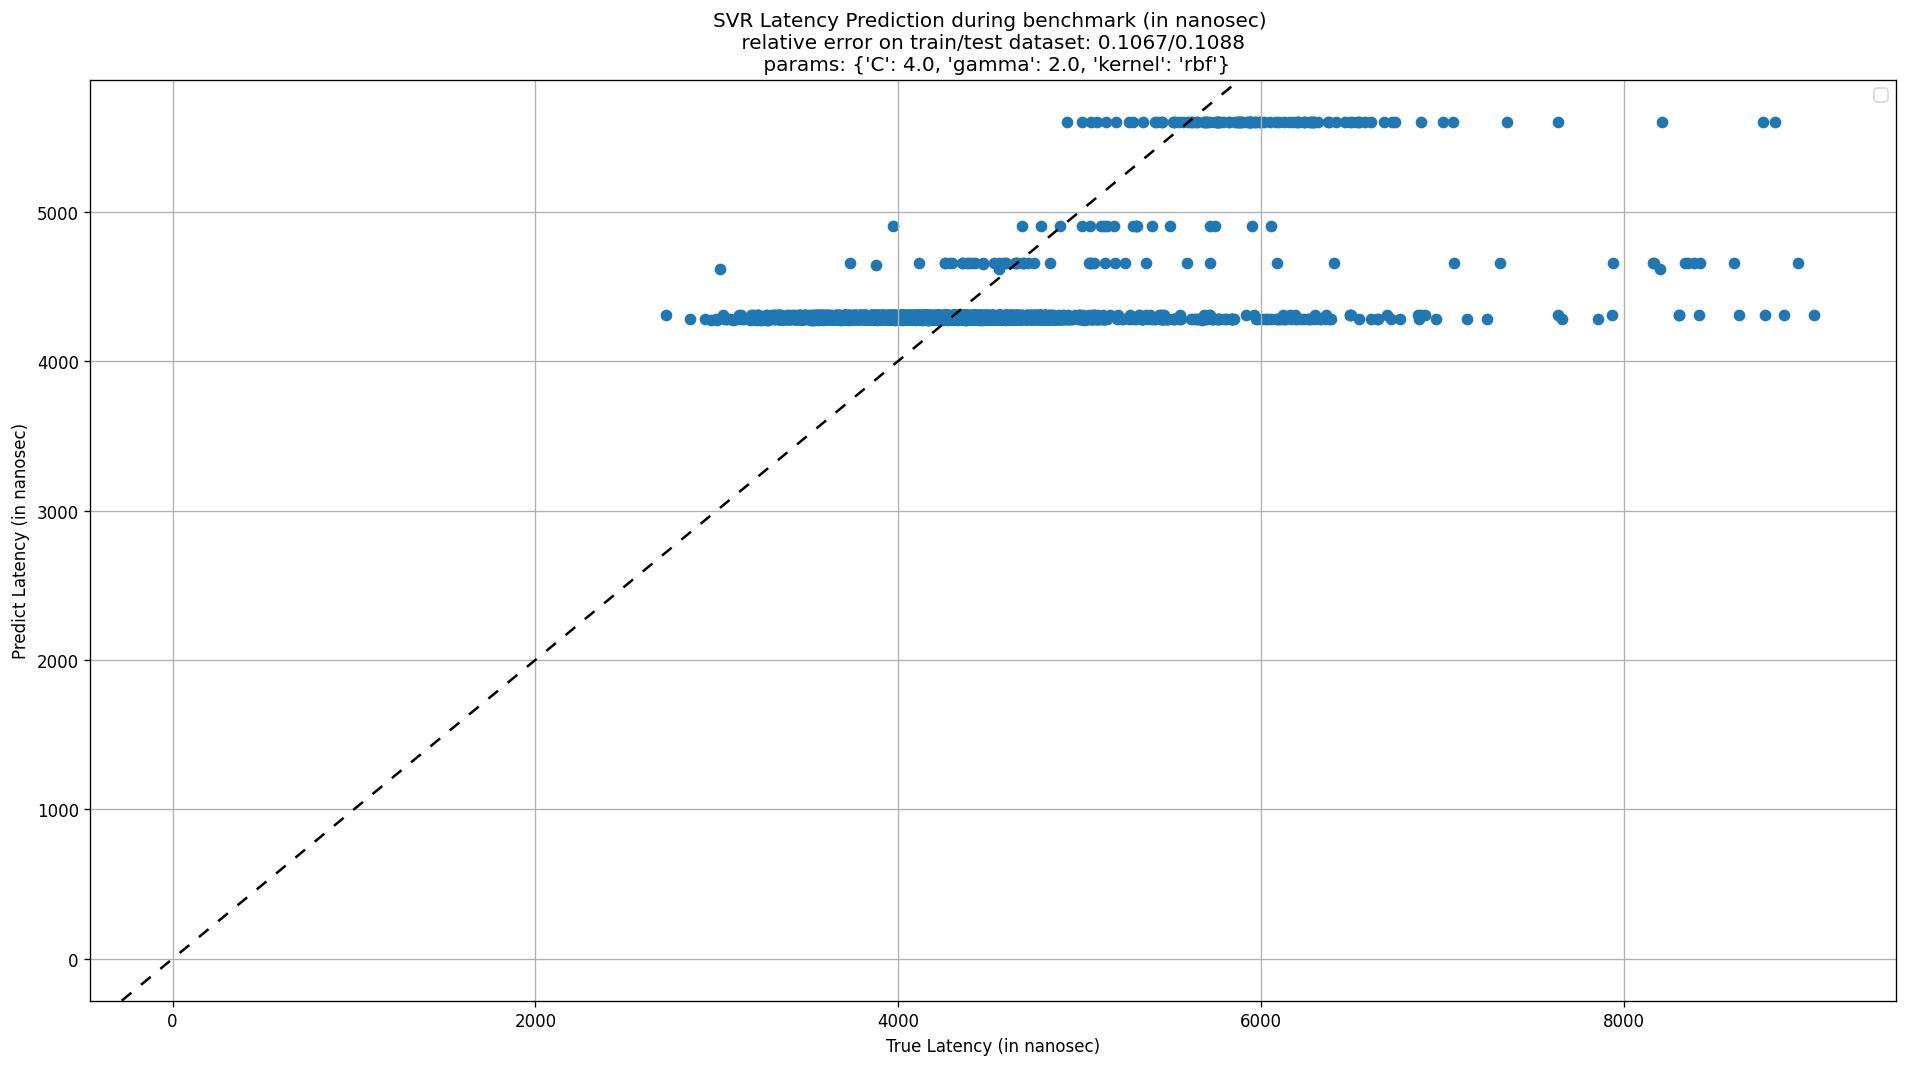

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.117/0.1212
Best Params: {'alpha': 1, 'epsilon': 1.1}


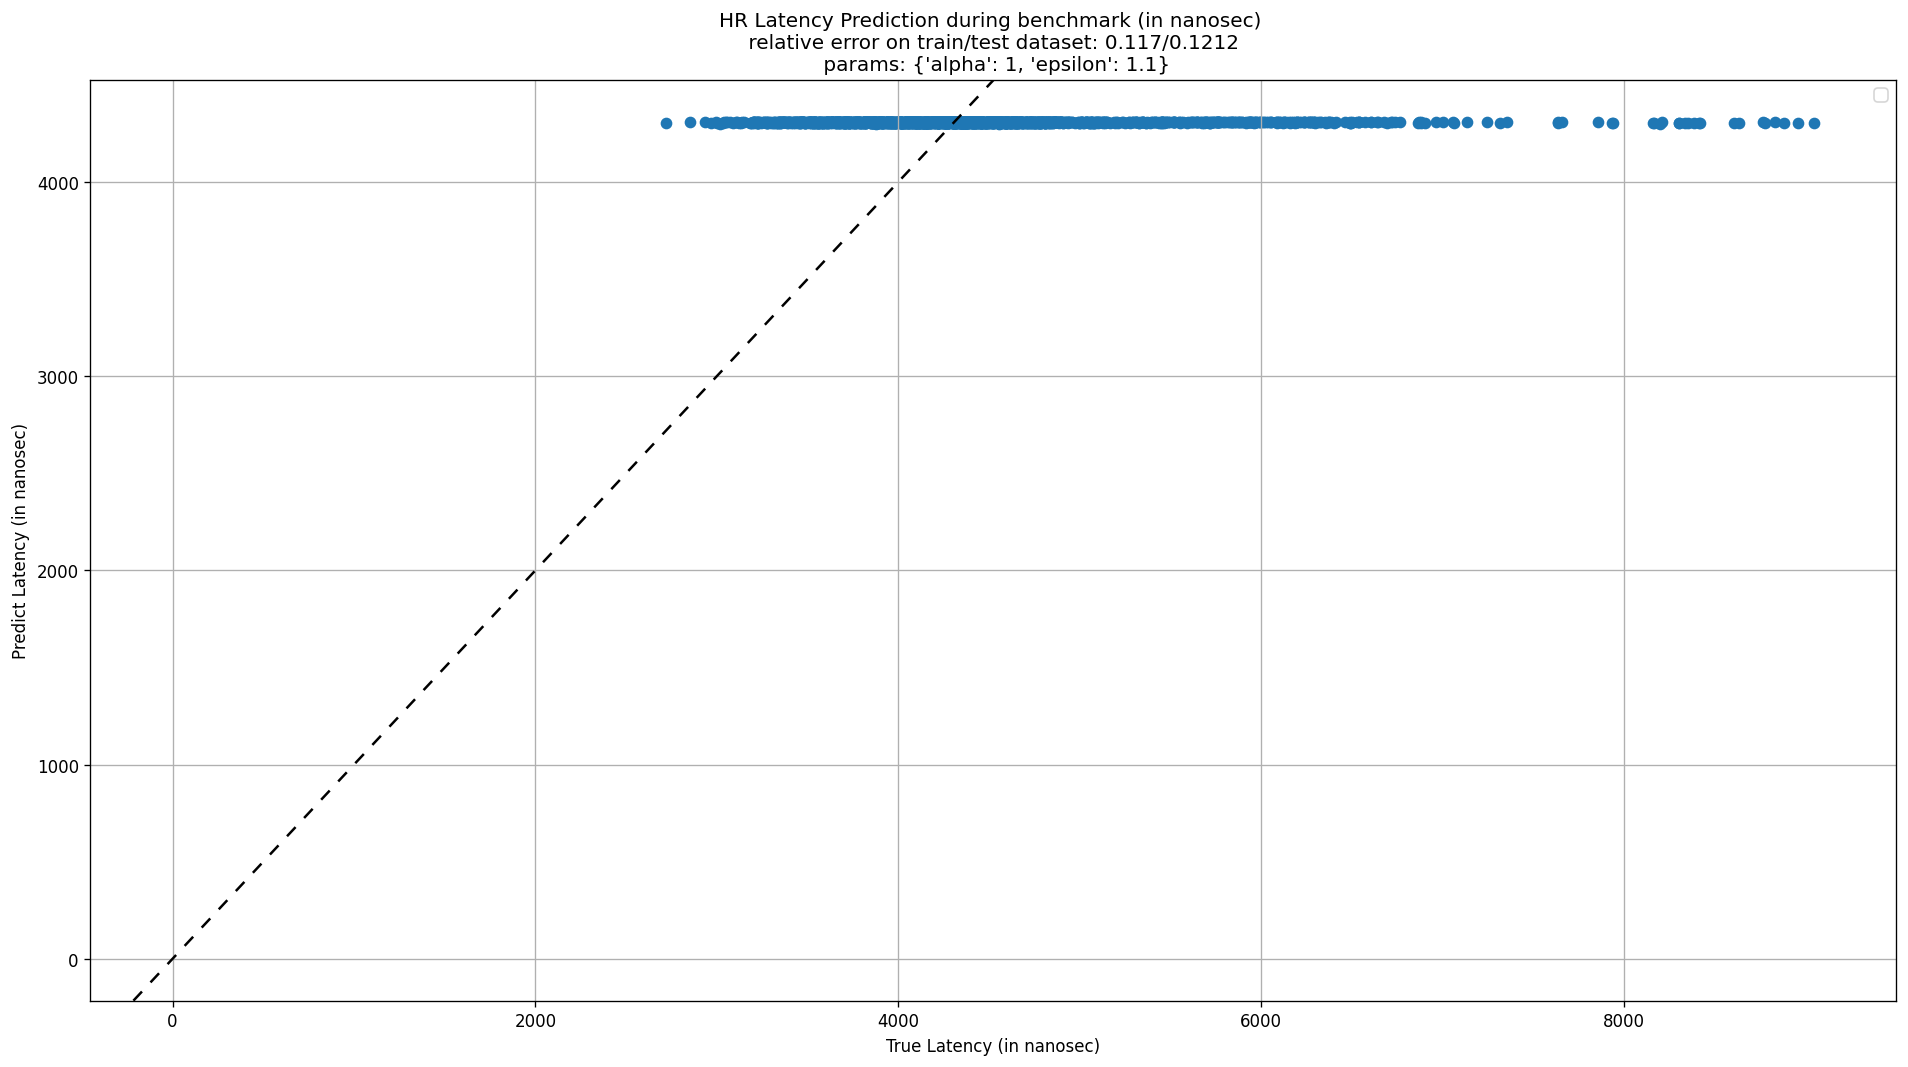

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1038/0.1069
Best Params: {'criterion': 'mae', 'max_depth': 5, 'n_estimators': 100, 'n_jobs': None, 'random_state': 0}


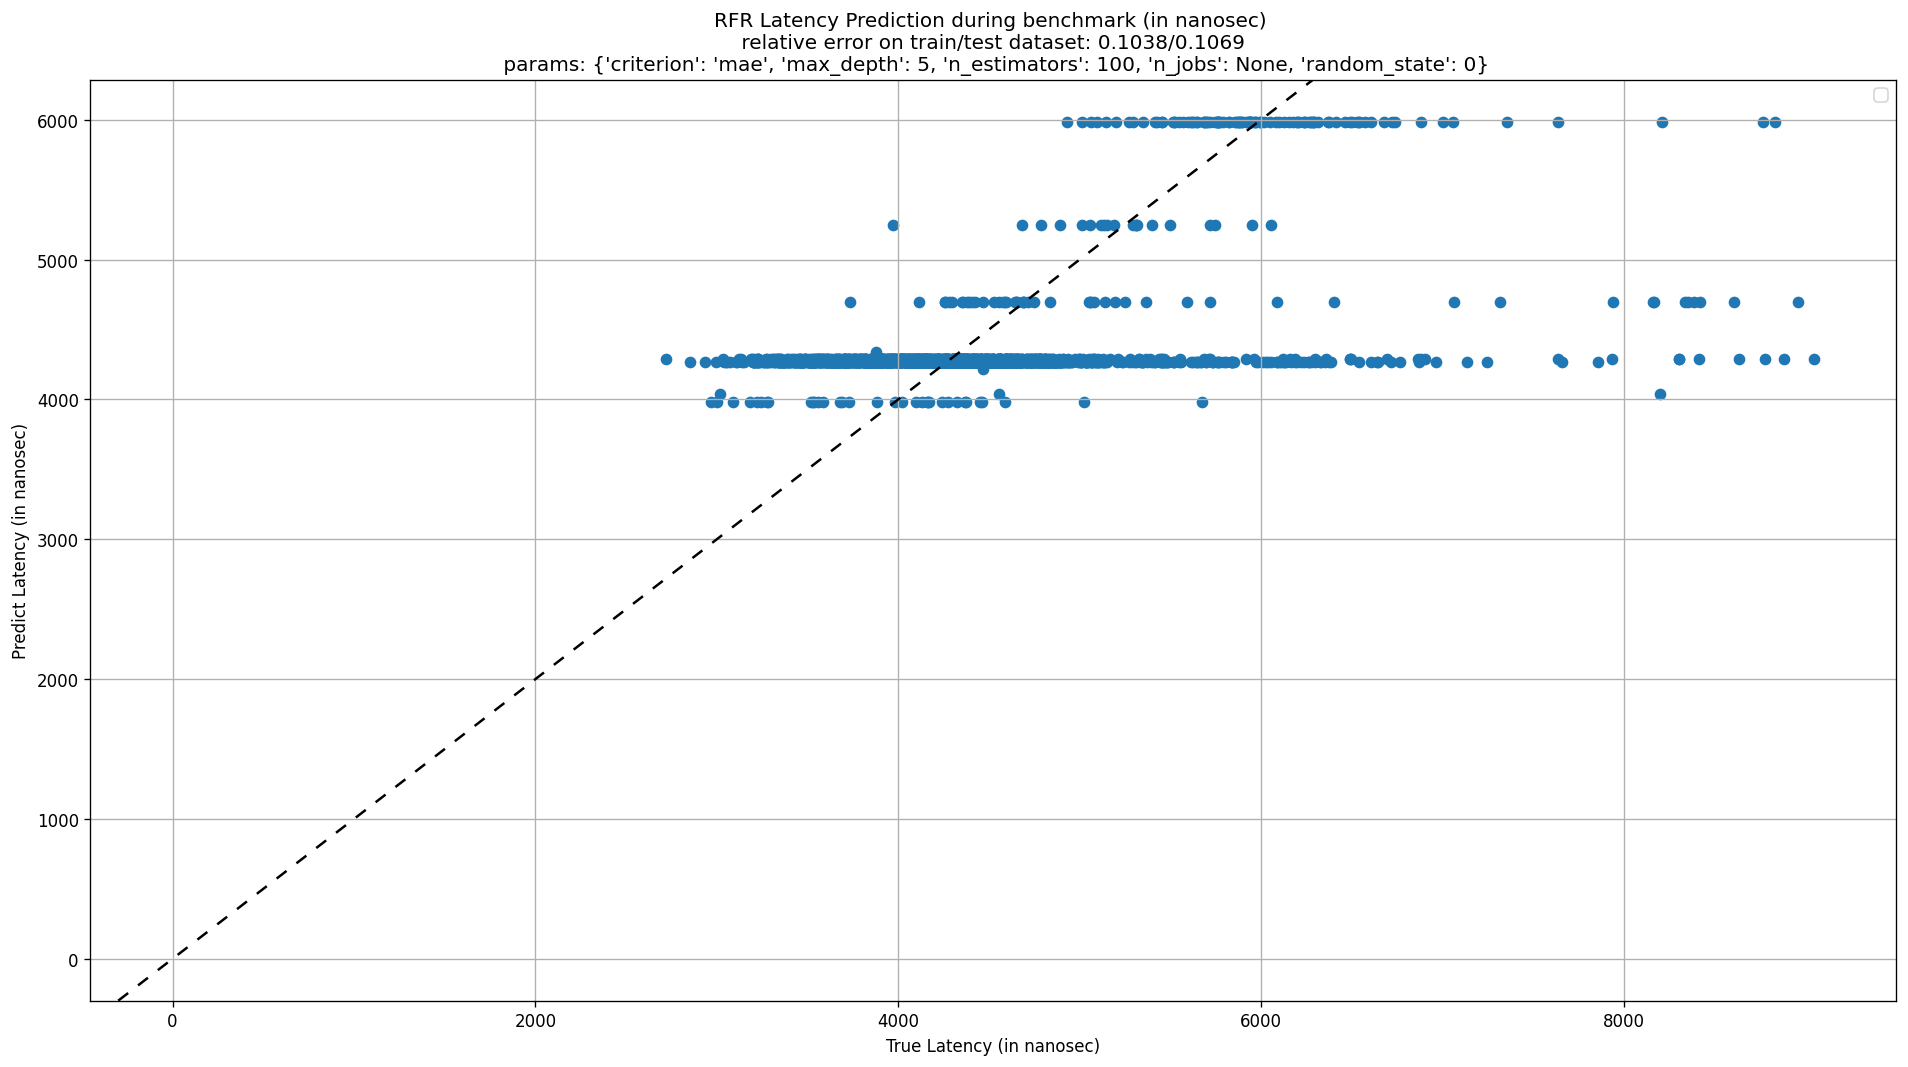

Warm Up Drop Timestamp: 369562672
In microsec, Number of bins: 12, nBins: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Mean Latency: 0.66, Std Latency: 0.68 (microsec)


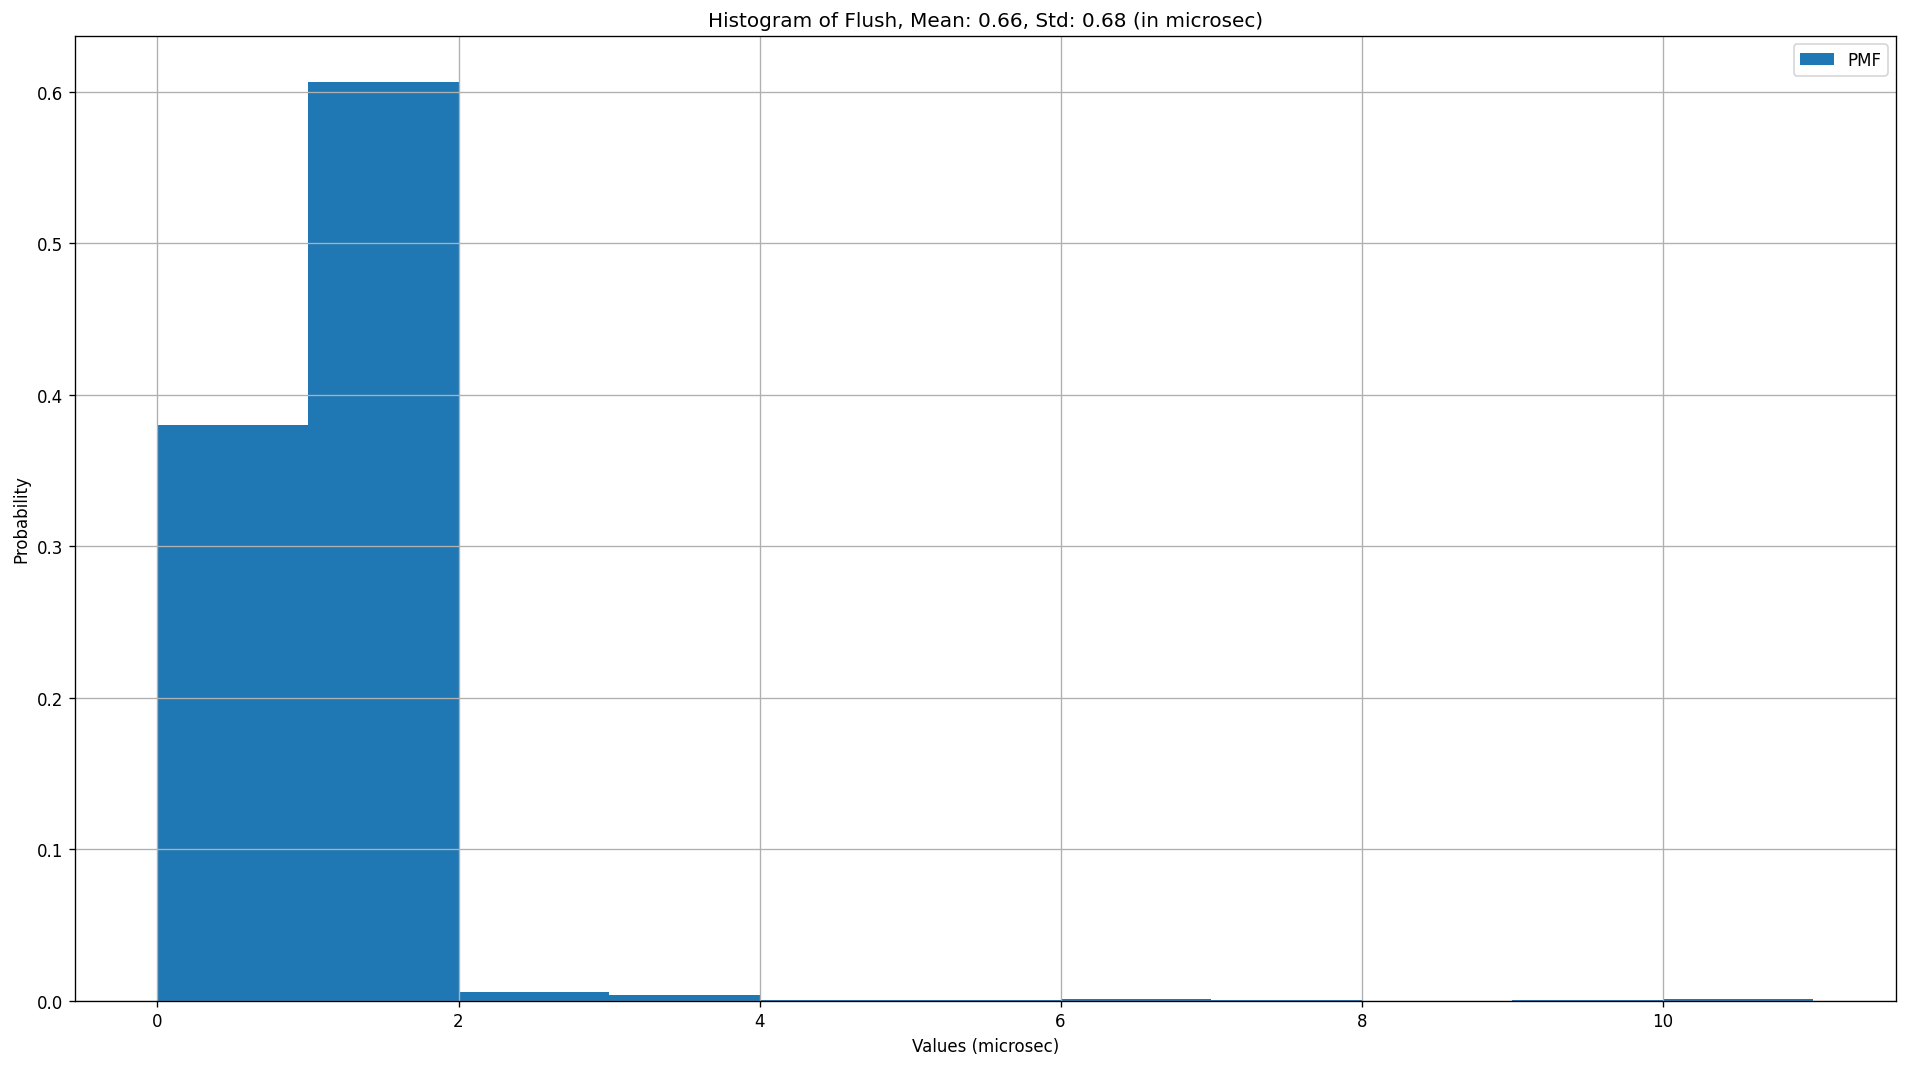

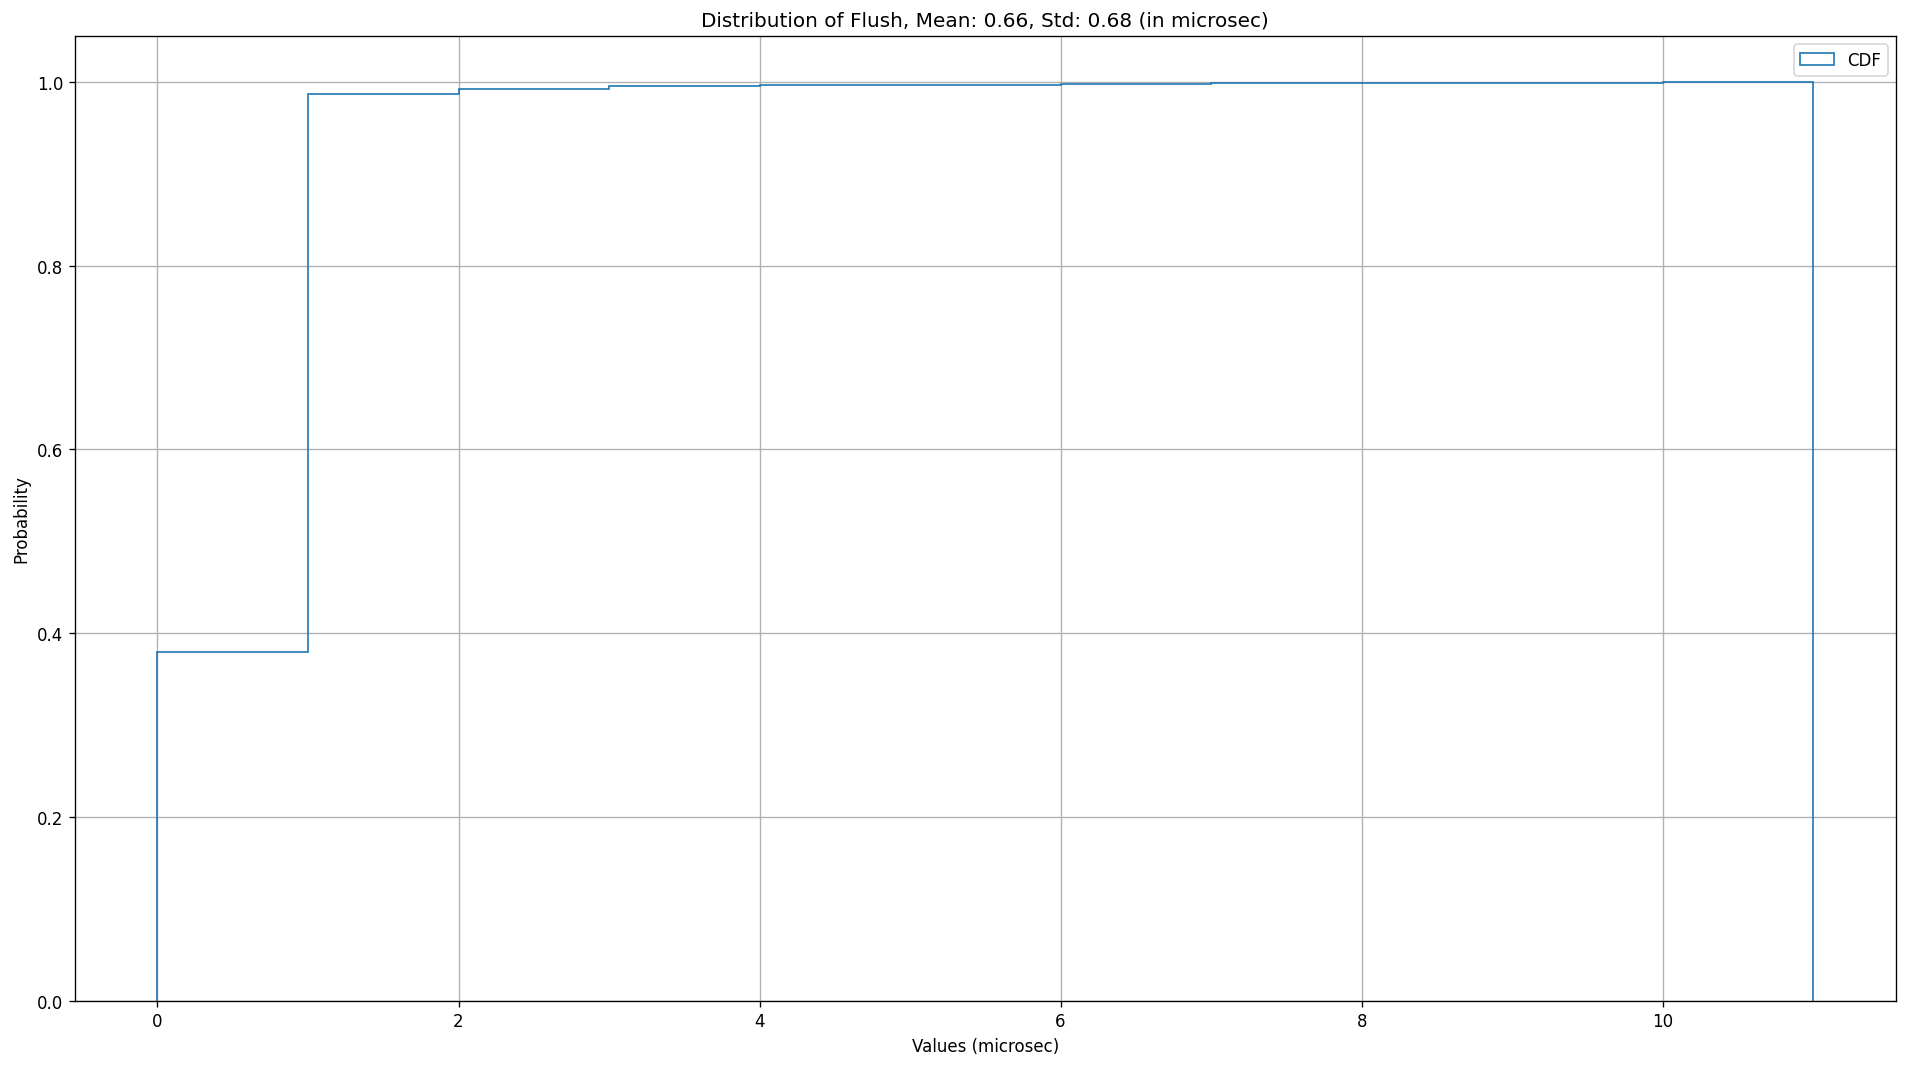

OU - Flush Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0               10              0                  1                50   
1               10              0                  1                50   
2               10              0                  1                50   
3               10              0                  1                50   
4               10              0                  1                50   
...            ...            ...                ...               ...   
9995            10              0                  1                50   
9996            10              0                  1                50   
9997            10              0                  1                50   
9998            10              0                  1                50   
9999            10              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 3.0                 20                    0   
1                 4.0                 20                    0   
2                 4.0                 20                    0   
3                 2.0                 20                    0   
4                 2.0                 20                    0   
...               ...                ...                  ...   
9995              0.0                 20                    0   
9996              4.0                 20                    0   
9997              4.0                 20                    0   
9998              4.0                 20                    0   
9999              0.0                 20                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                        10                       0   
1                0                        10                       0   
2                0                        10                       0   
3                0                        10                       0   
4                0                        10                       0   
...            ...                       ...                     ...   
9995             0                        10                       0   
9996             0                        10                       0   
9997             0                        10                       0   
9998             0                        10                       0   
9999             0                        10                       0   

      Num of Threads  
0                 45  
1                 67  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU - Flush Targets shape: (10000,)


0       6598
1       6097
2       7591
3       5615
4       6062
        ... 
9995     507
9996     499
9997     472
9998     410
9999     470
Name: Flush, Length: 10000, dtype: int64

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1865/0.1923
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


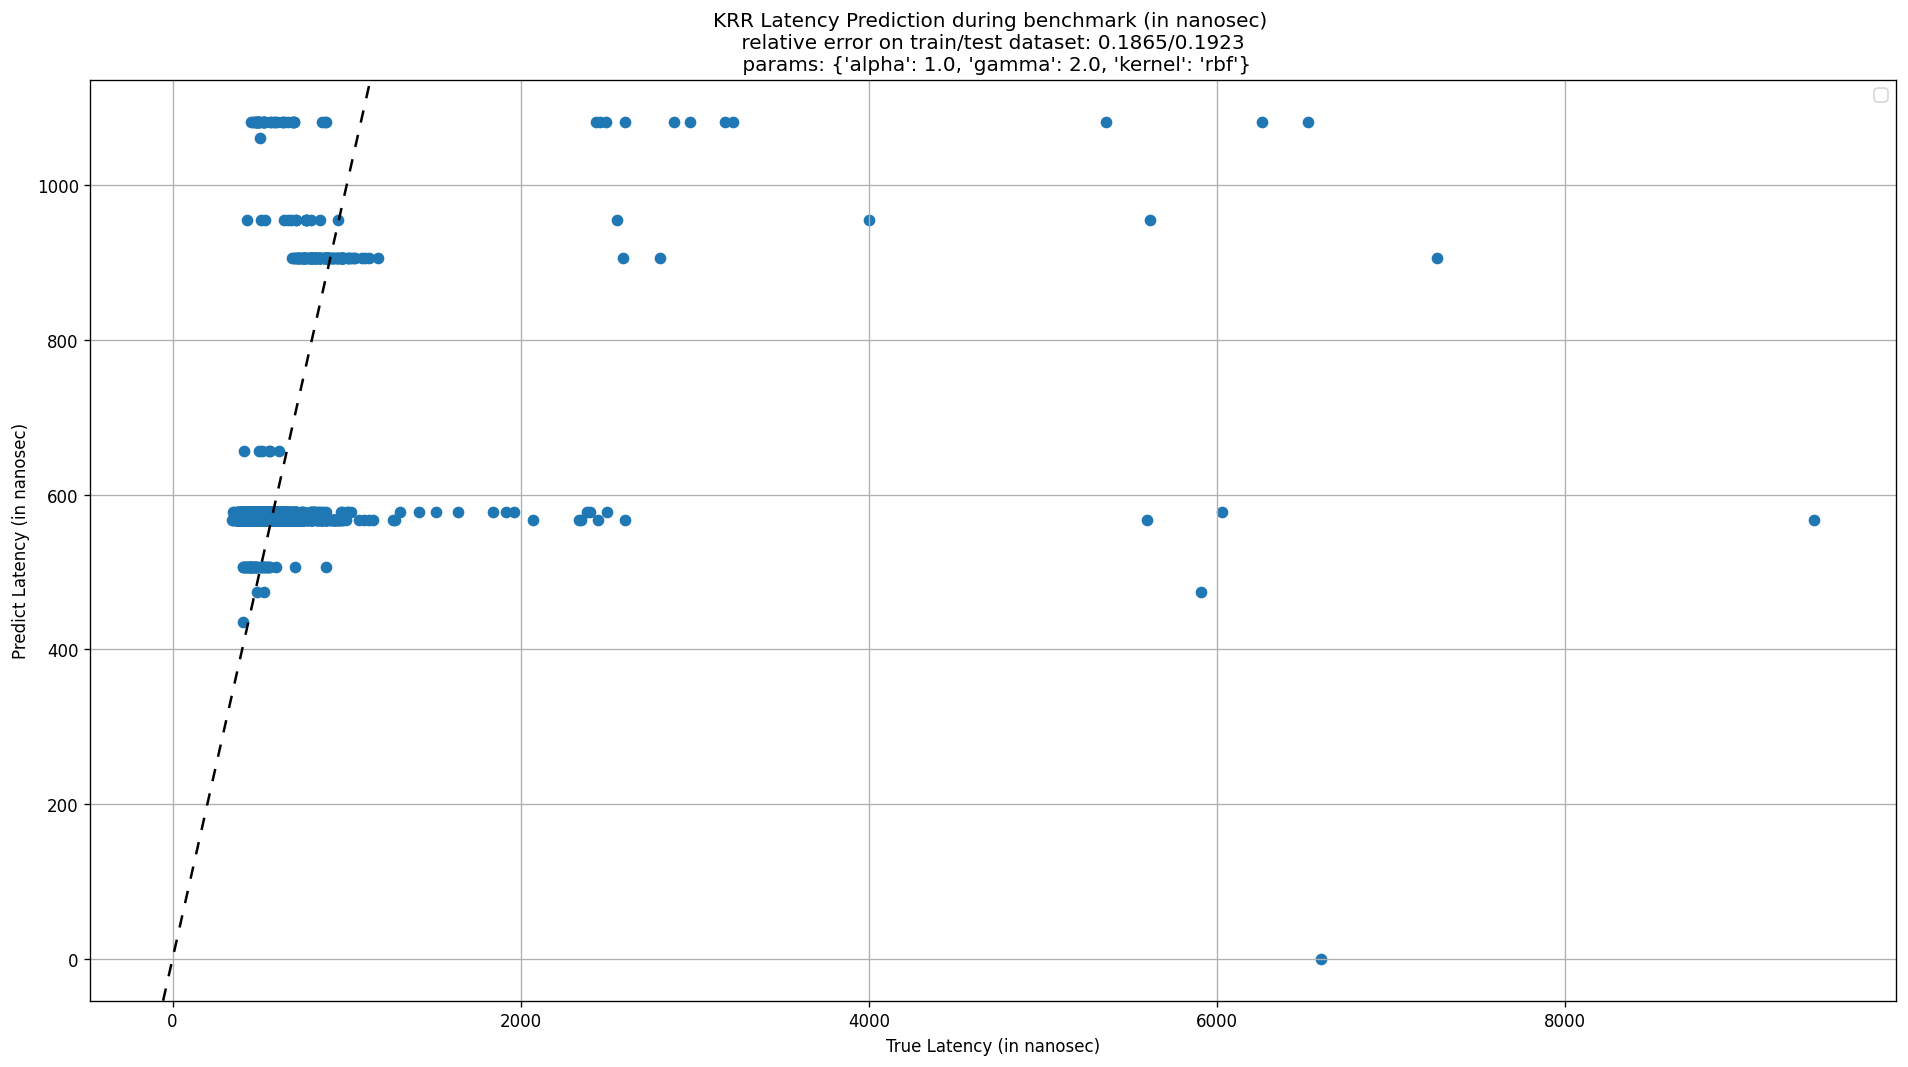

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.15479949 -0.14881689
 -0.14633507 -0.14554986 -0.15303183 -0.14425864 -0.1426067  -0.14237204
 -0.15077122 -0.14184441 -0.14091254 -0.14085737 -0.14778678 -0.14069567
 -0.14032179 -0.14030921]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1403/0.1468
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


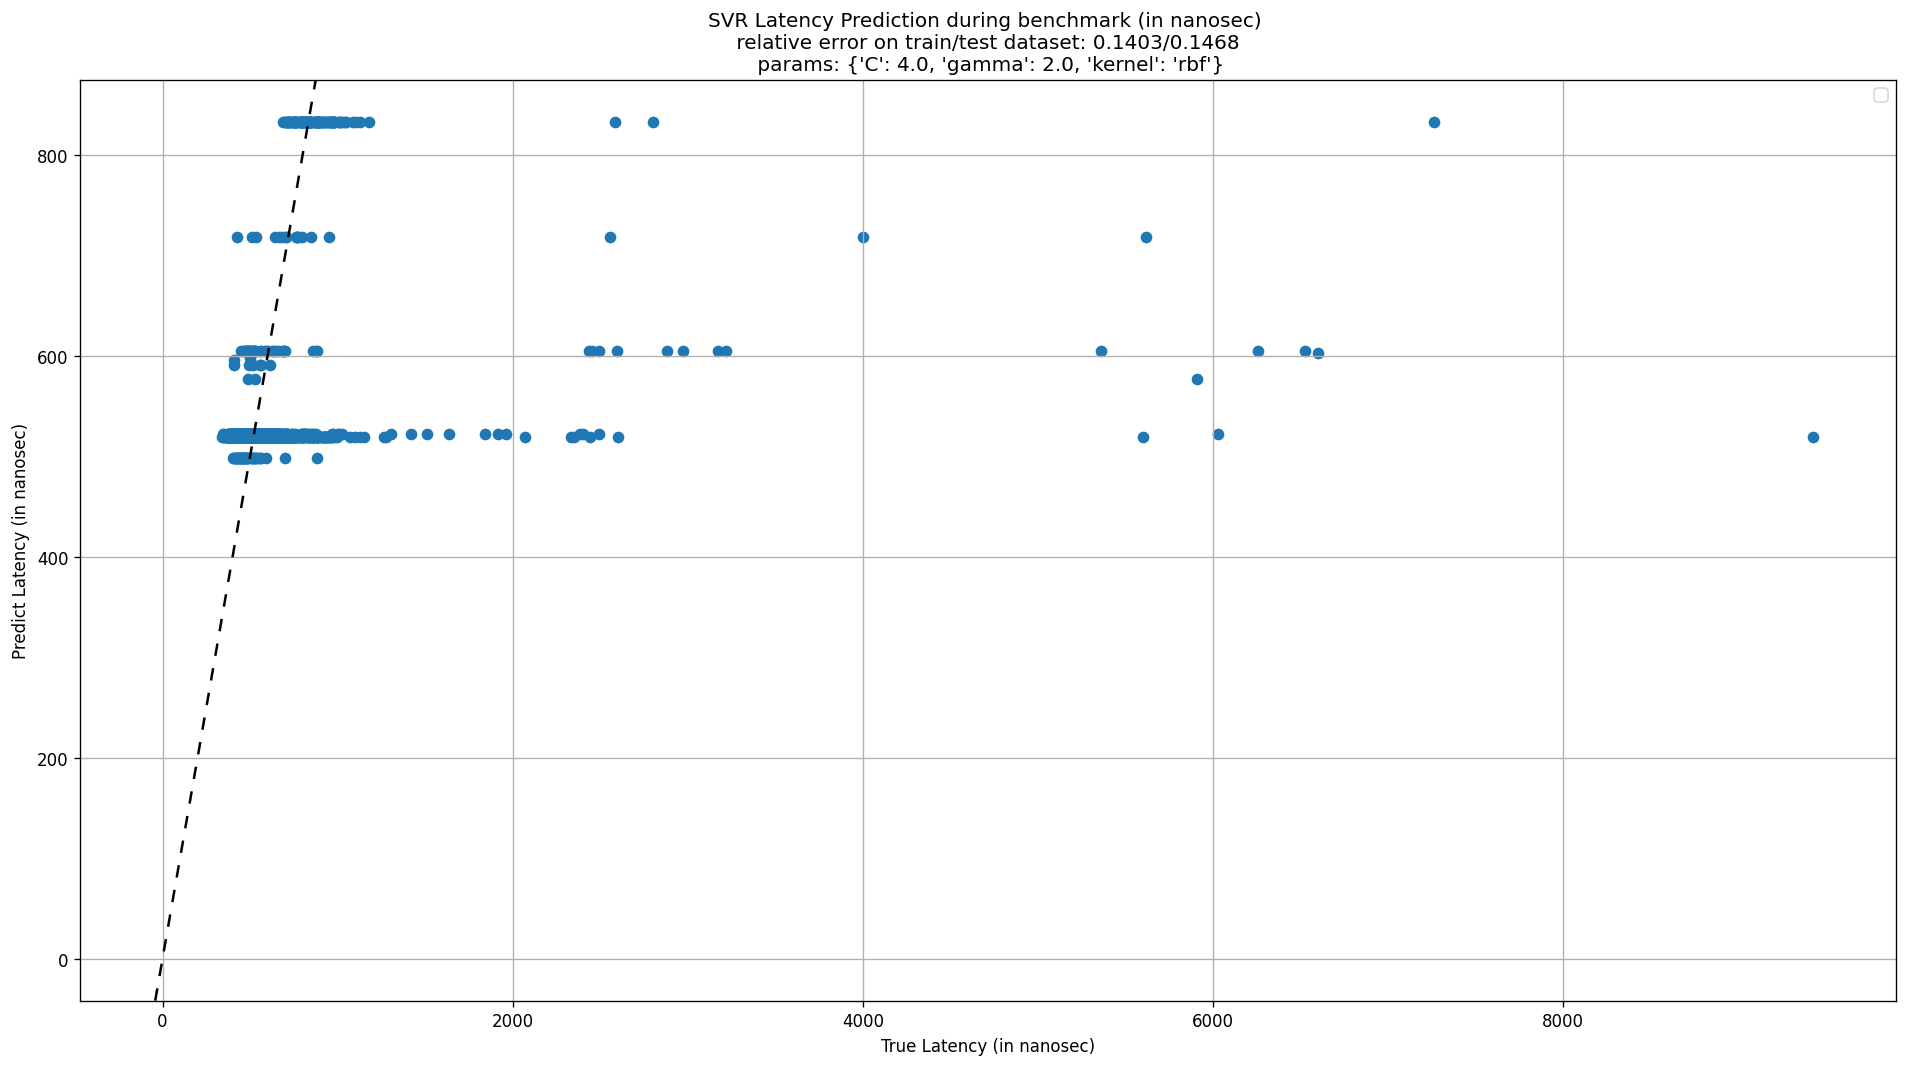

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1581/0.1643
Best Params: {'alpha': 1, 'epsilon': 1.1}


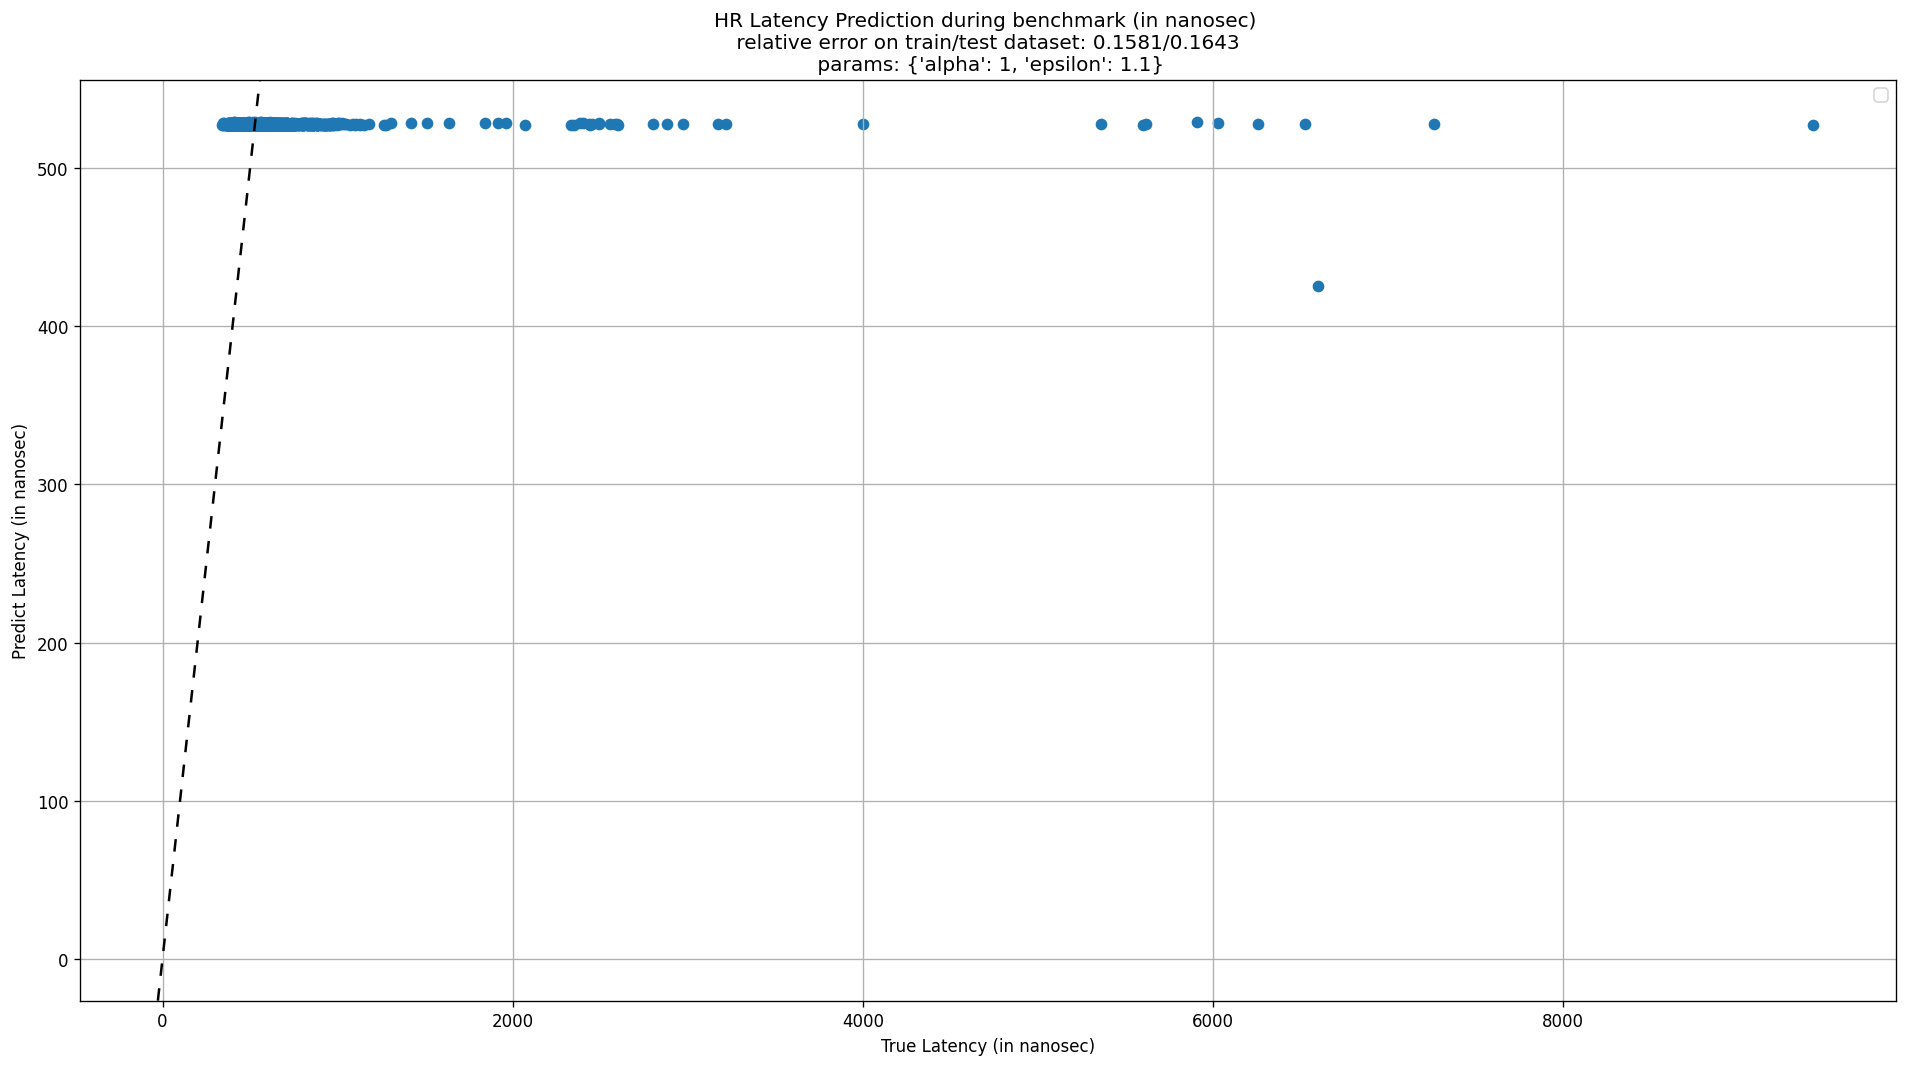

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1401/0.1464
Best Params: {'criterion': 'mae', 'max_depth': 5, 'n_estimators': 500, 'n_jobs': None, 'random_state': 0}


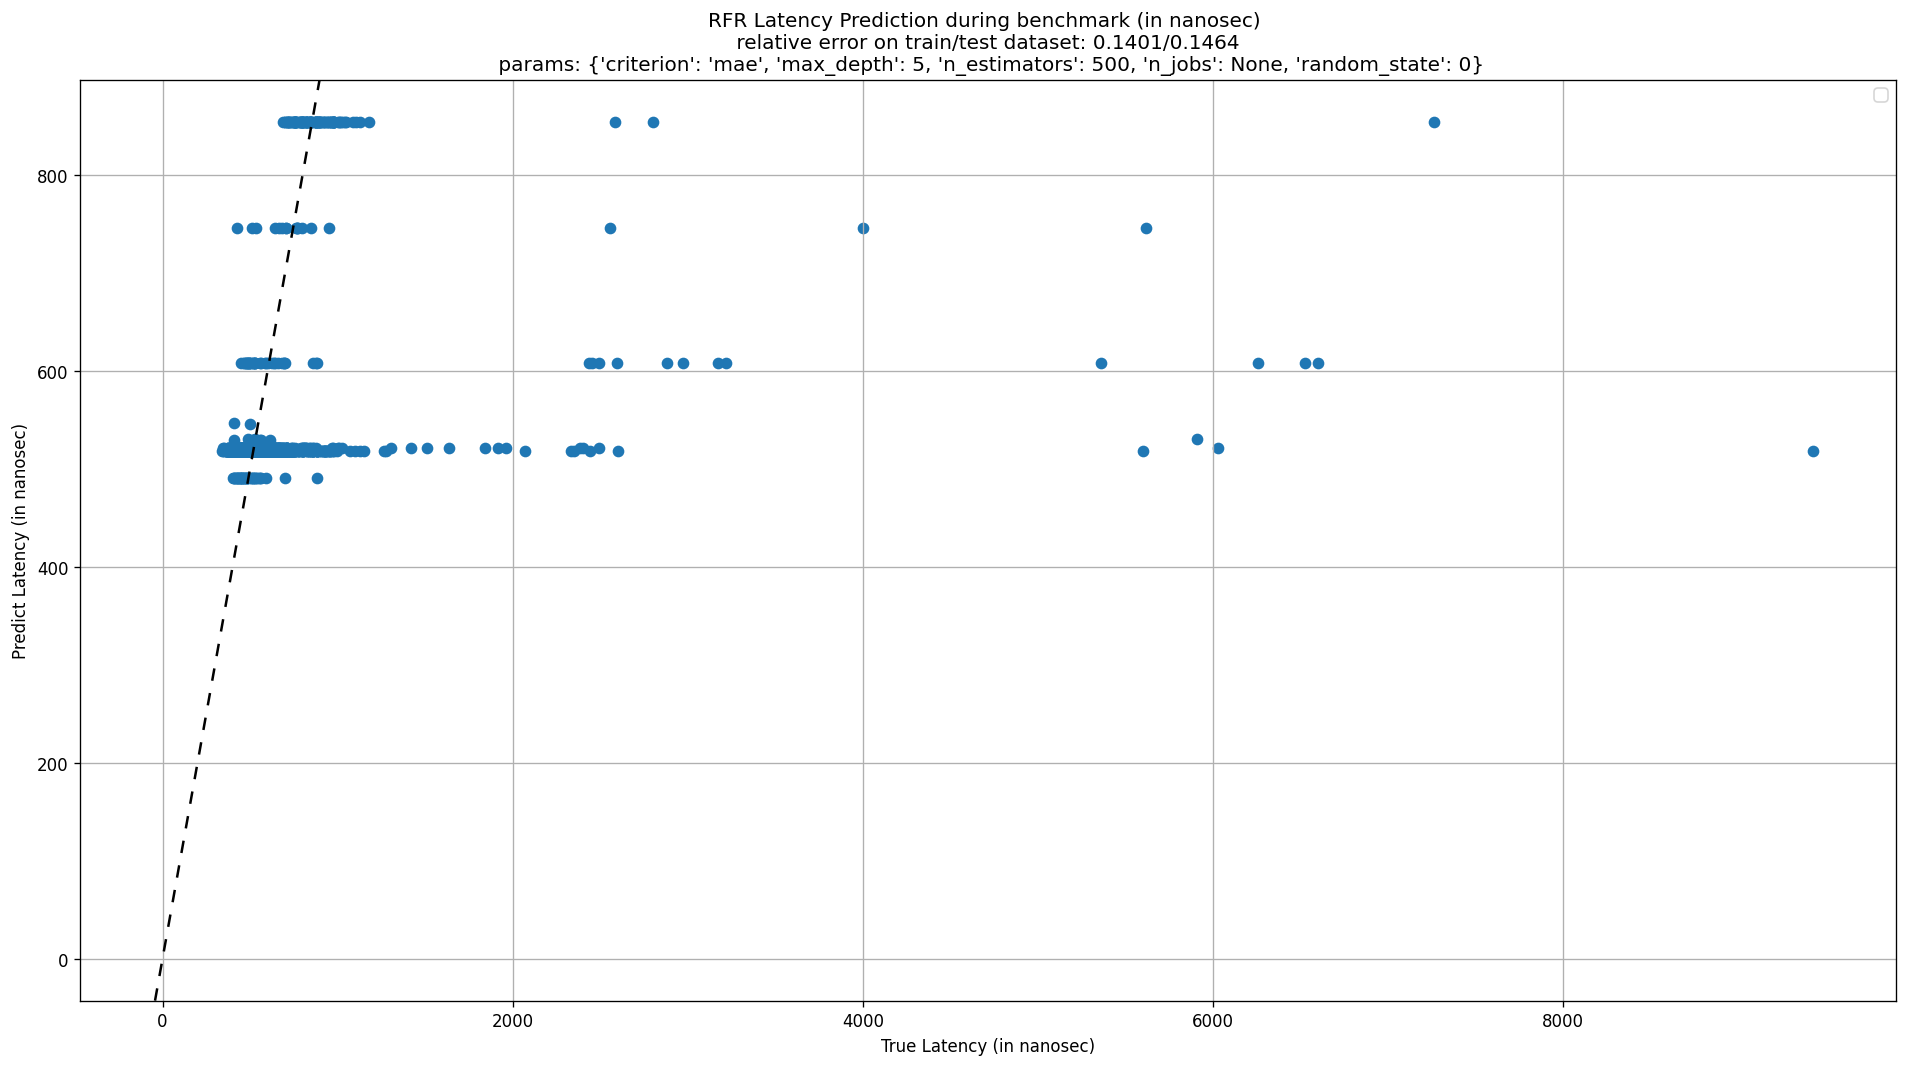

Warm Up Drop Timestamp: 369562672
In microsec, Number of bins: 3, nBins: [1. 2. 3.]
Mean Latency: 1.33, Std Latency: 0.47 (microsec)


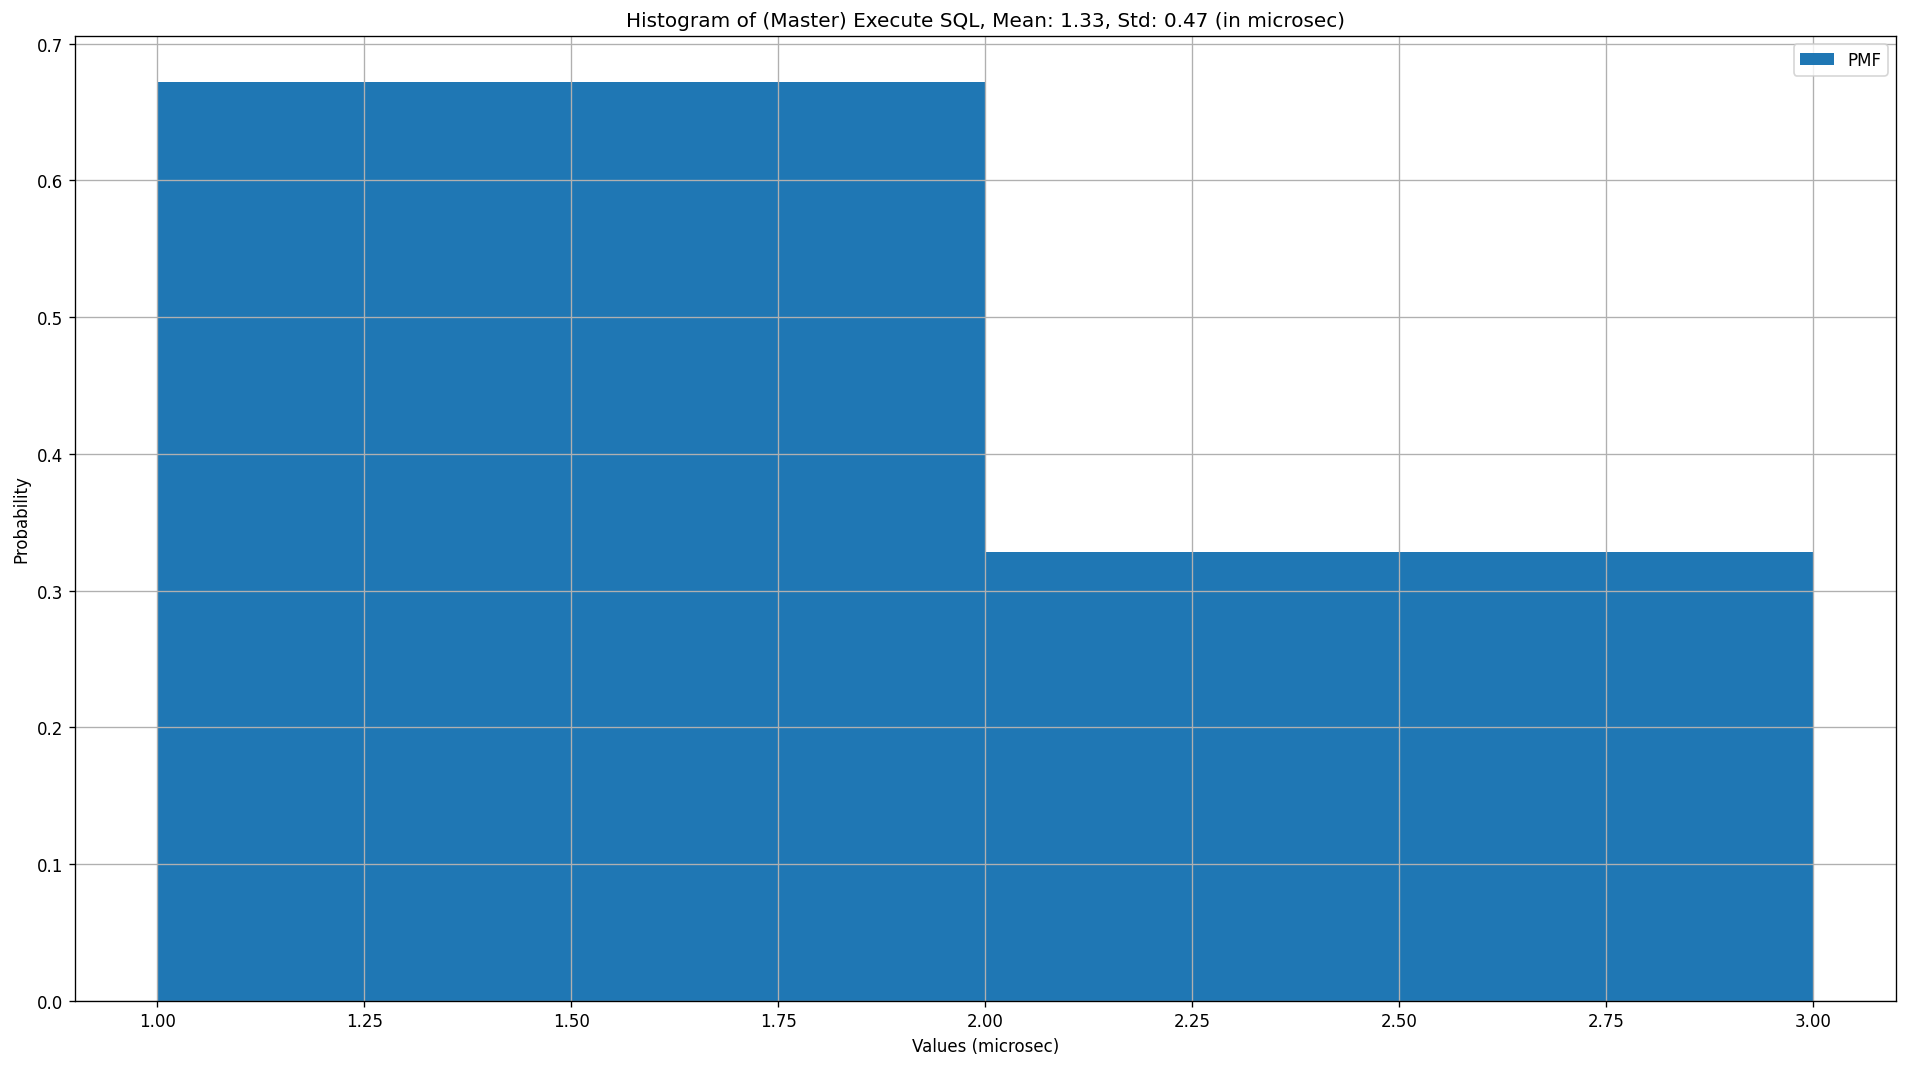

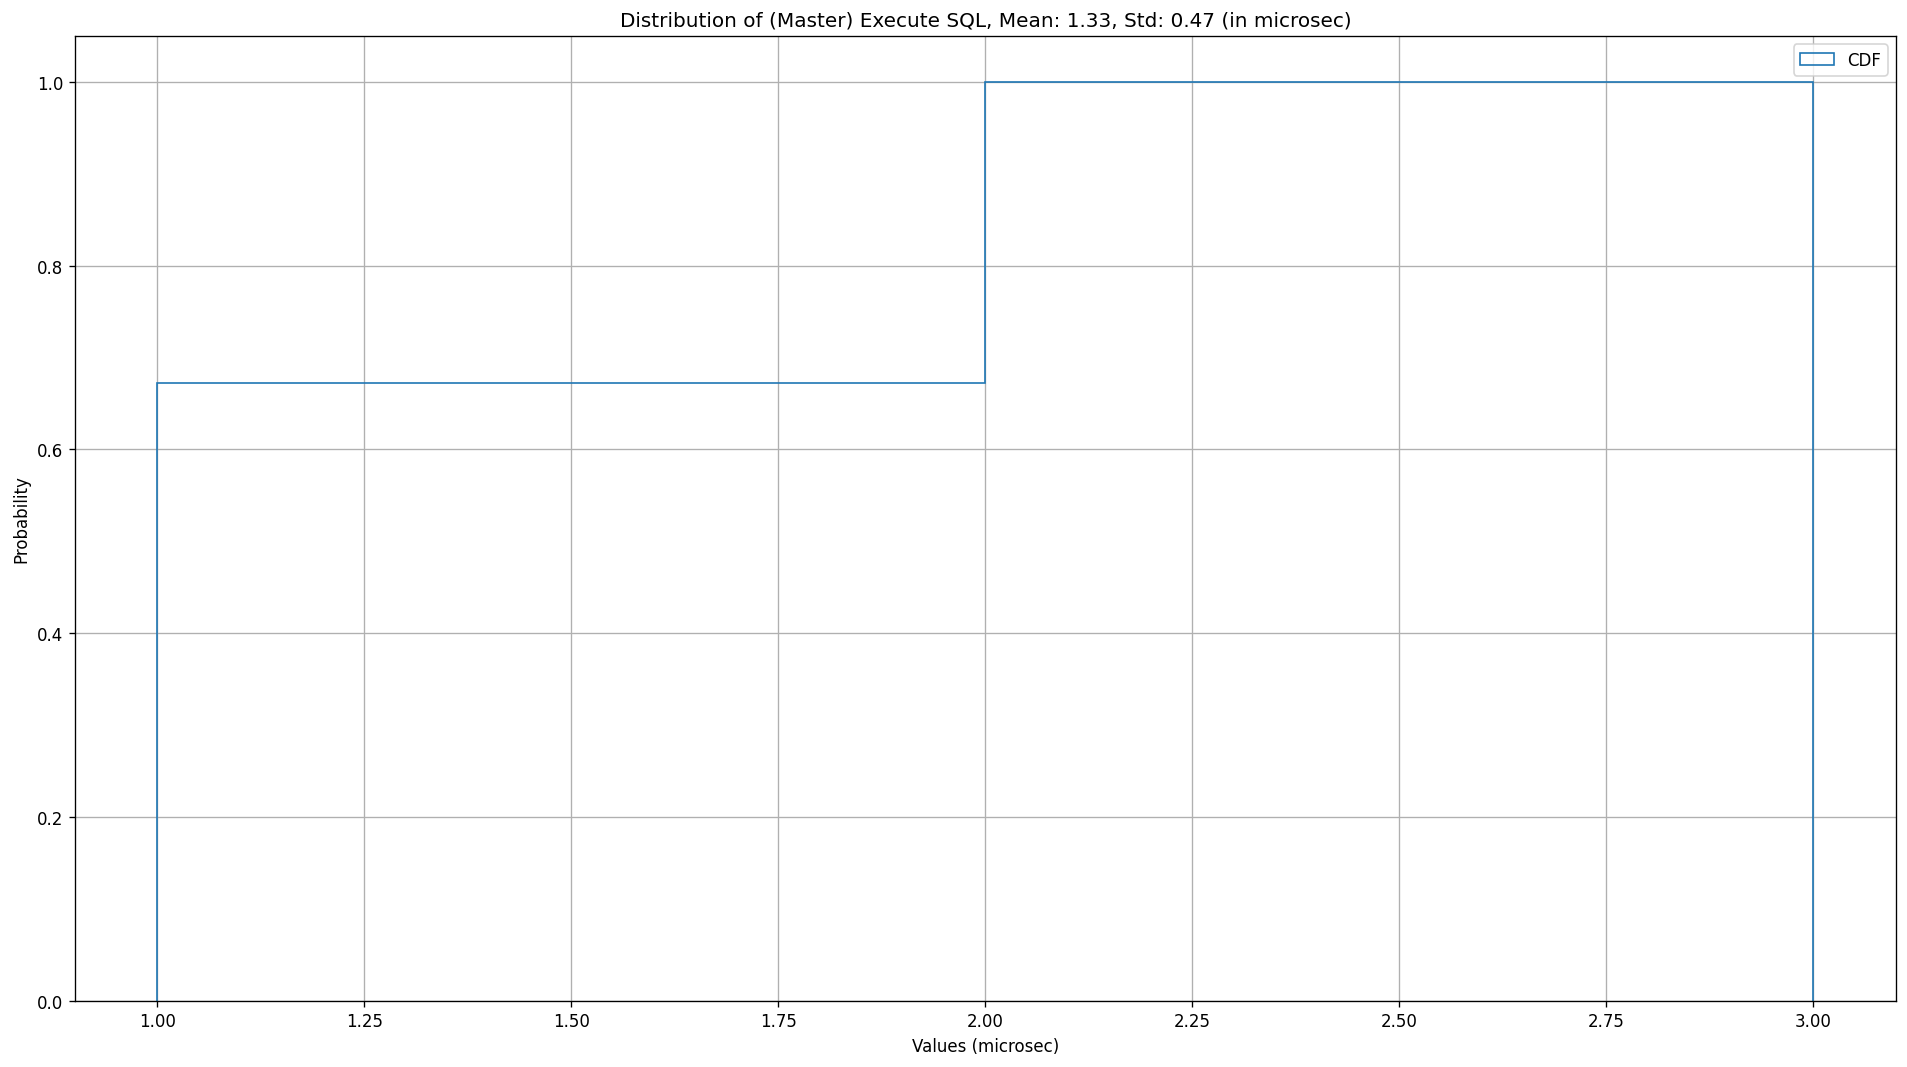

OU - (Master) Execute SQL Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0               10              0                  1                50   
1               10              0                  1                50   
2               10              0                  1                50   
3               10              0                  1                50   
4               10              0                  1                50   
...            ...            ...                ...               ...   
9995            10              0                  1                50   
9996            10              0                  1                50   
9997            10              0                  1                50   
9998            10              0                  1                50   
9999            10              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 0.0                 20                    0   
1                 0.0                 20                    0   
2                 0.0                 20                    0   
3                 0.0                 20                    0   
4                 0.0                 20                    0   
...               ...                ...                  ...   
9995              0.0                 20                    0   
9996              0.0                 20                    0   
9997              0.0                 20                    0   
9998              0.0                 20                    0   
9999              0.0                 20                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                        10                       0   
1                0                        10                       0   
2                0                        10                       0   
3                0                        10                       0   
4                0                        10                       0   
...            ...                       ...                     ...   
9995             0                        10                       0   
9996             0                        10                       0   
9997             0                        10                       0   
9998             0                        10                       0   
9999             0                        10                       0   

      Num of Threads  
0                 67  
1                 67  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU - (Master) Execute SQL Targets shape: (10000,)


0       1109
1       1291
2       1442
3       1200
4       1356
        ... 
9995    1244
9996    1470
9997    1356
9998    1549
9999    1358
Name: (Master) Execute SQL, Length: 10000, dtype: int64

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1121/0.1117
Best Params: {'alpha': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}


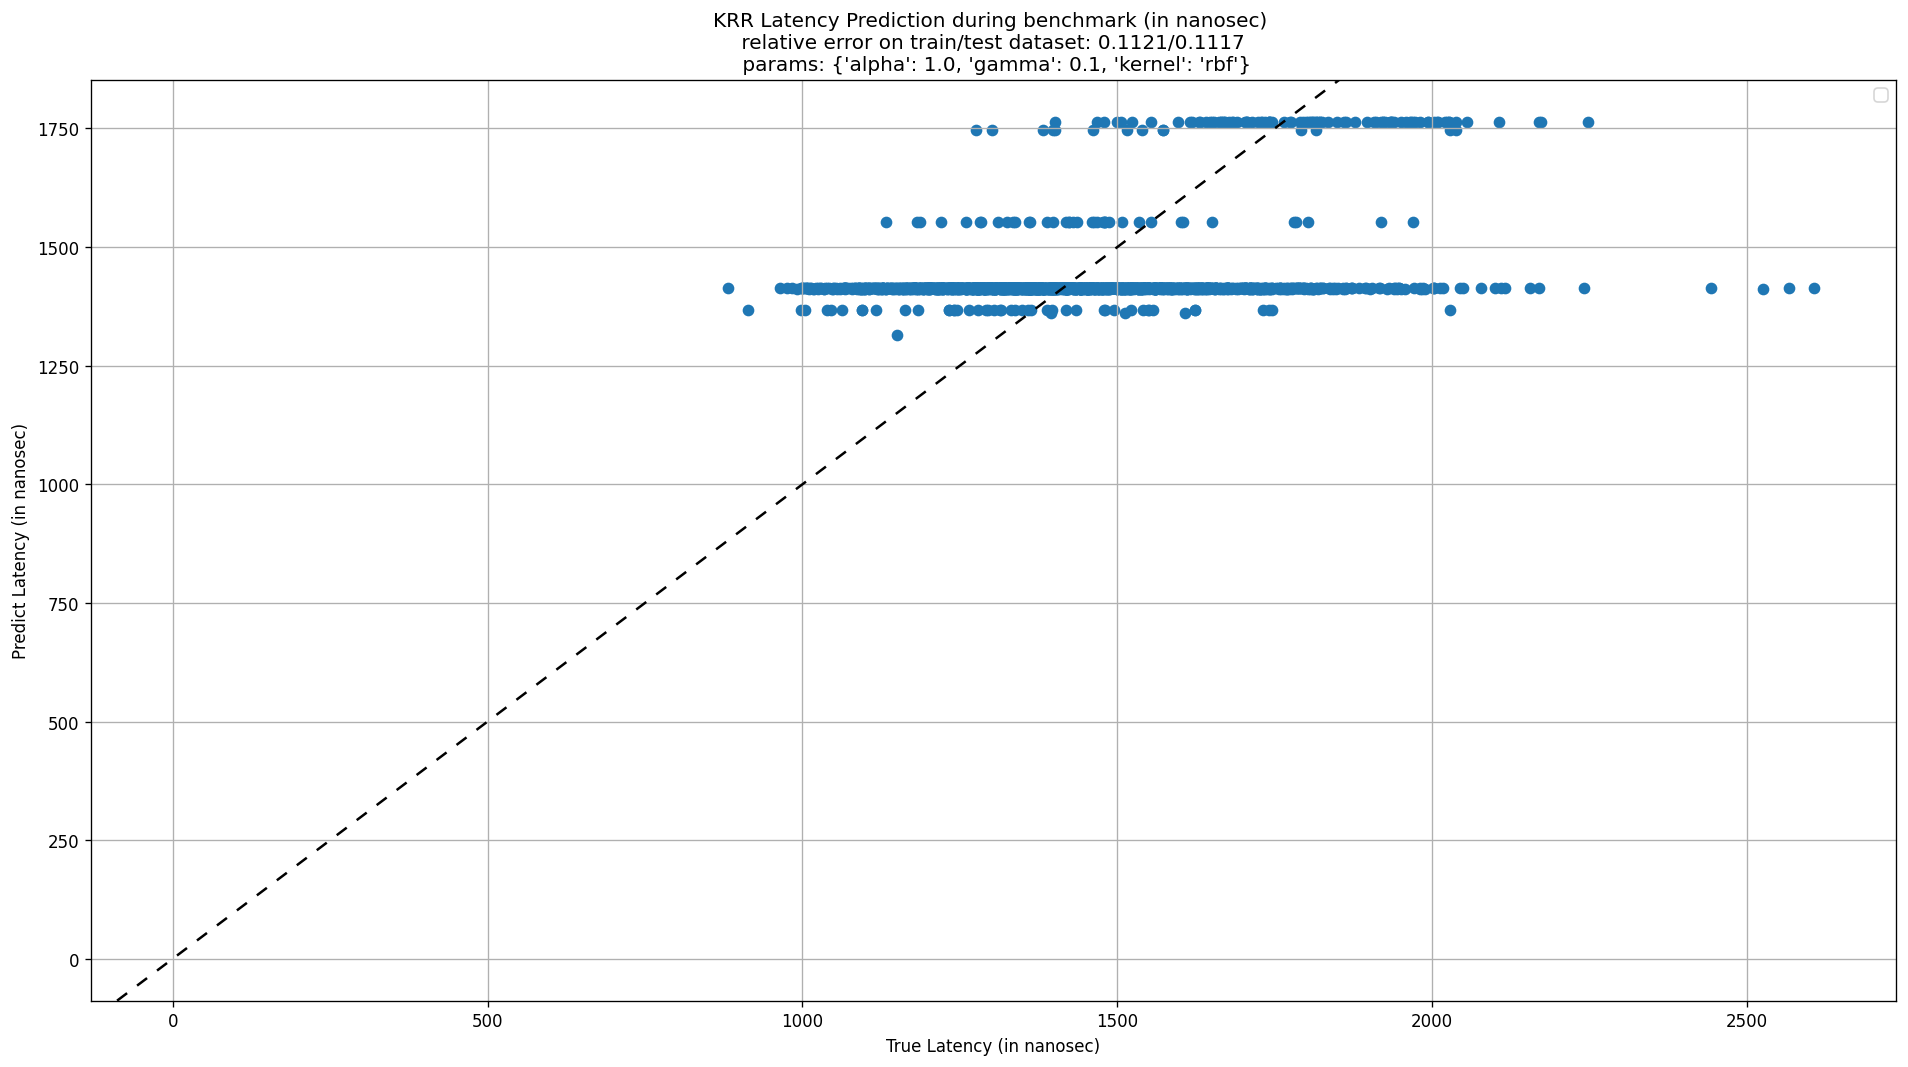

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.11537124 -0.11313361
 -0.11241126 -0.11211612 -0.11460266 -0.11148281 -0.11095498 -0.11076441
 -0.11343181 -0.11024021 -0.10996336 -0.10998349 -0.11213235 -0.10963387
 -0.1094933  -0.1095373 ]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1095/0.109
Best Params: {'C': 4.0, 'gamma': 1.0, 'kernel': 'rbf'}


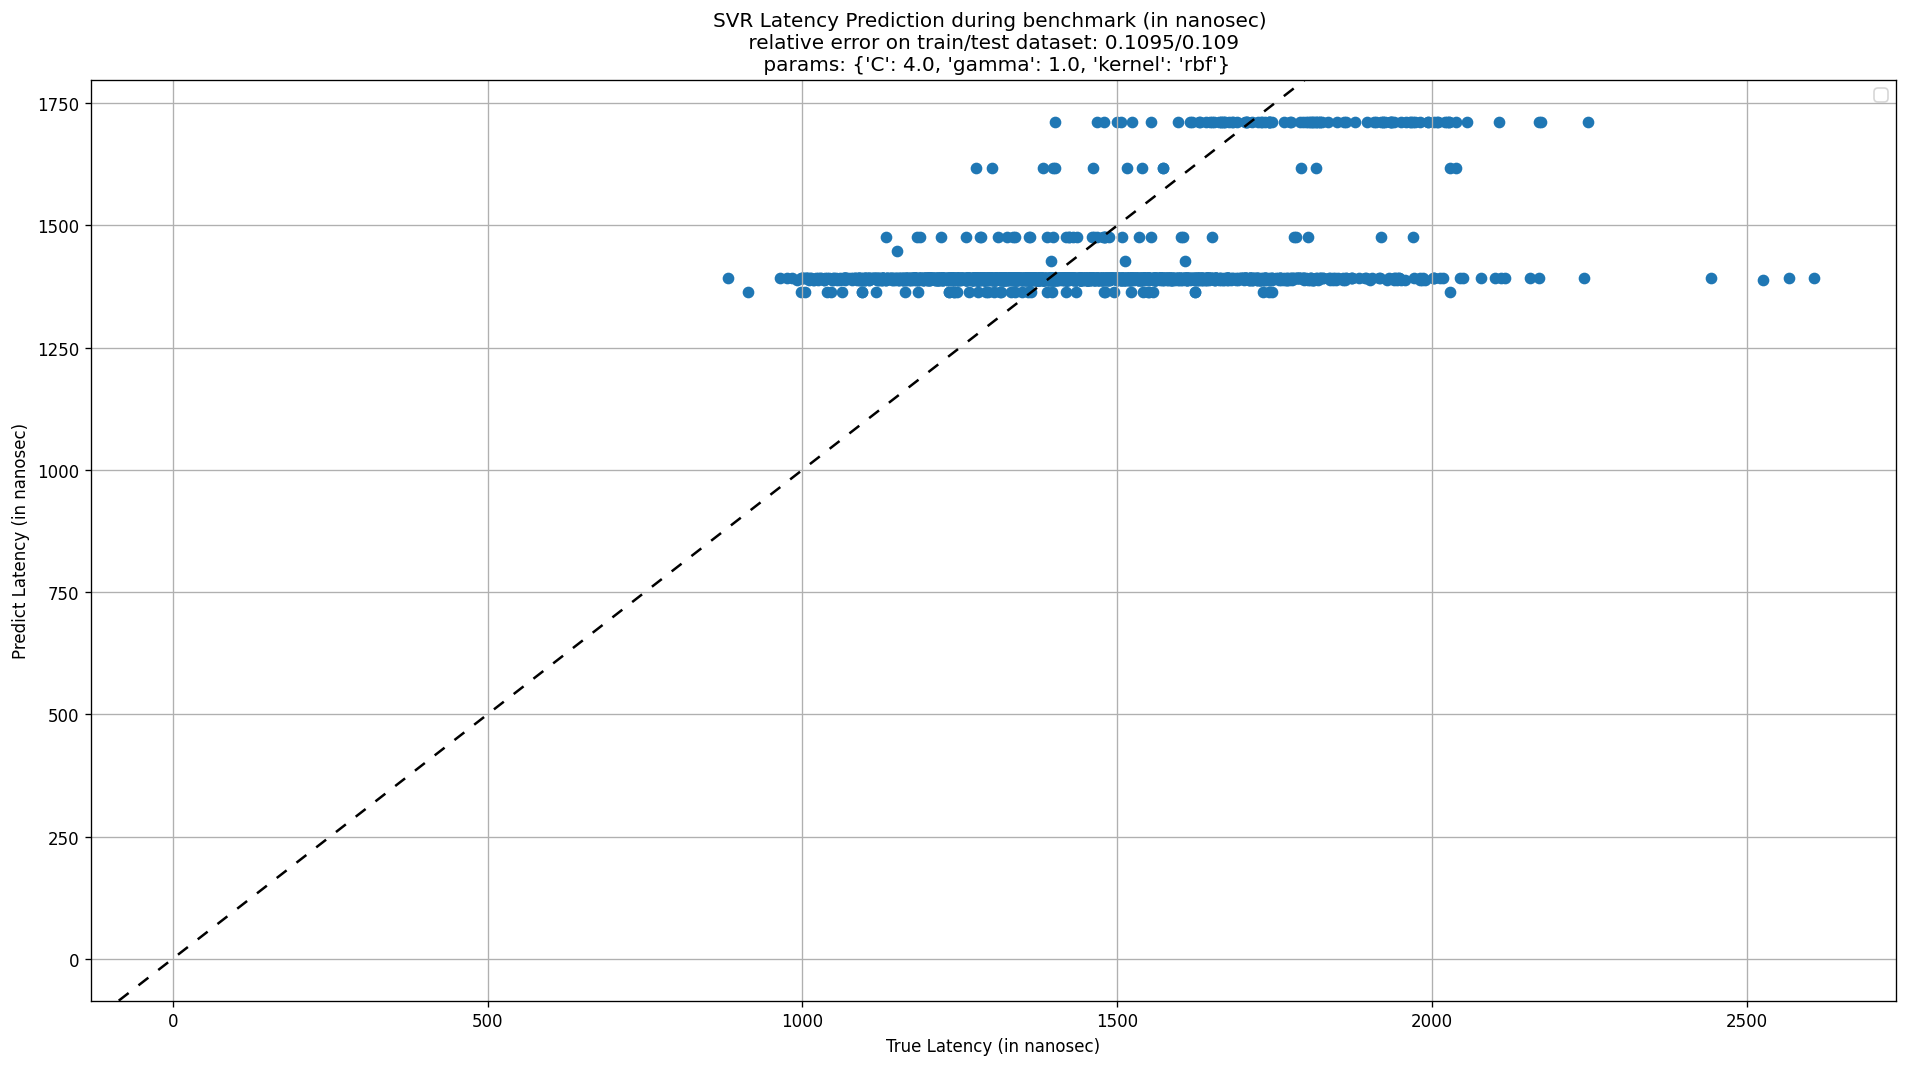

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1165/0.1165
Best Params: {'alpha': 1, 'epsilon': 1.1}


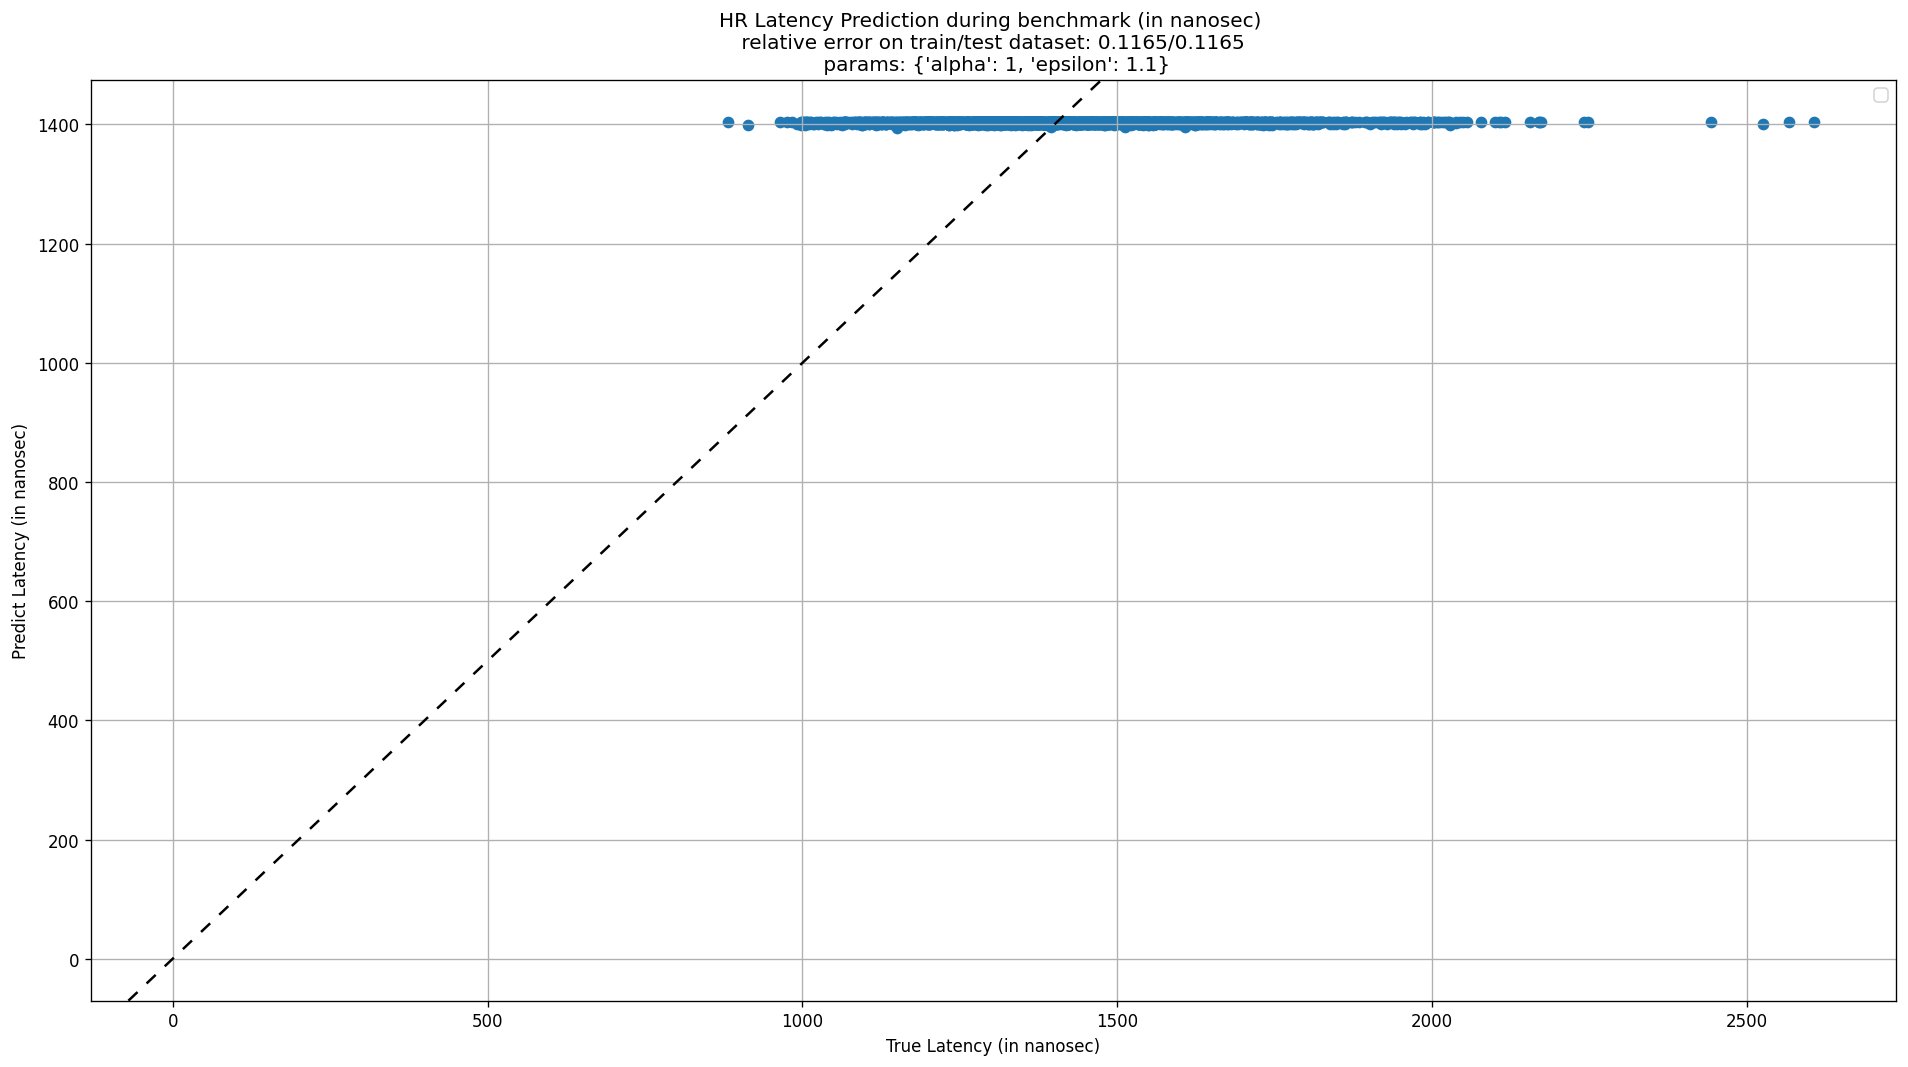

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1092/0.1089
Best Params: {'criterion': 'mae', 'max_depth': 3, 'n_estimators': 100, 'n_jobs': None, 'random_state': 0}


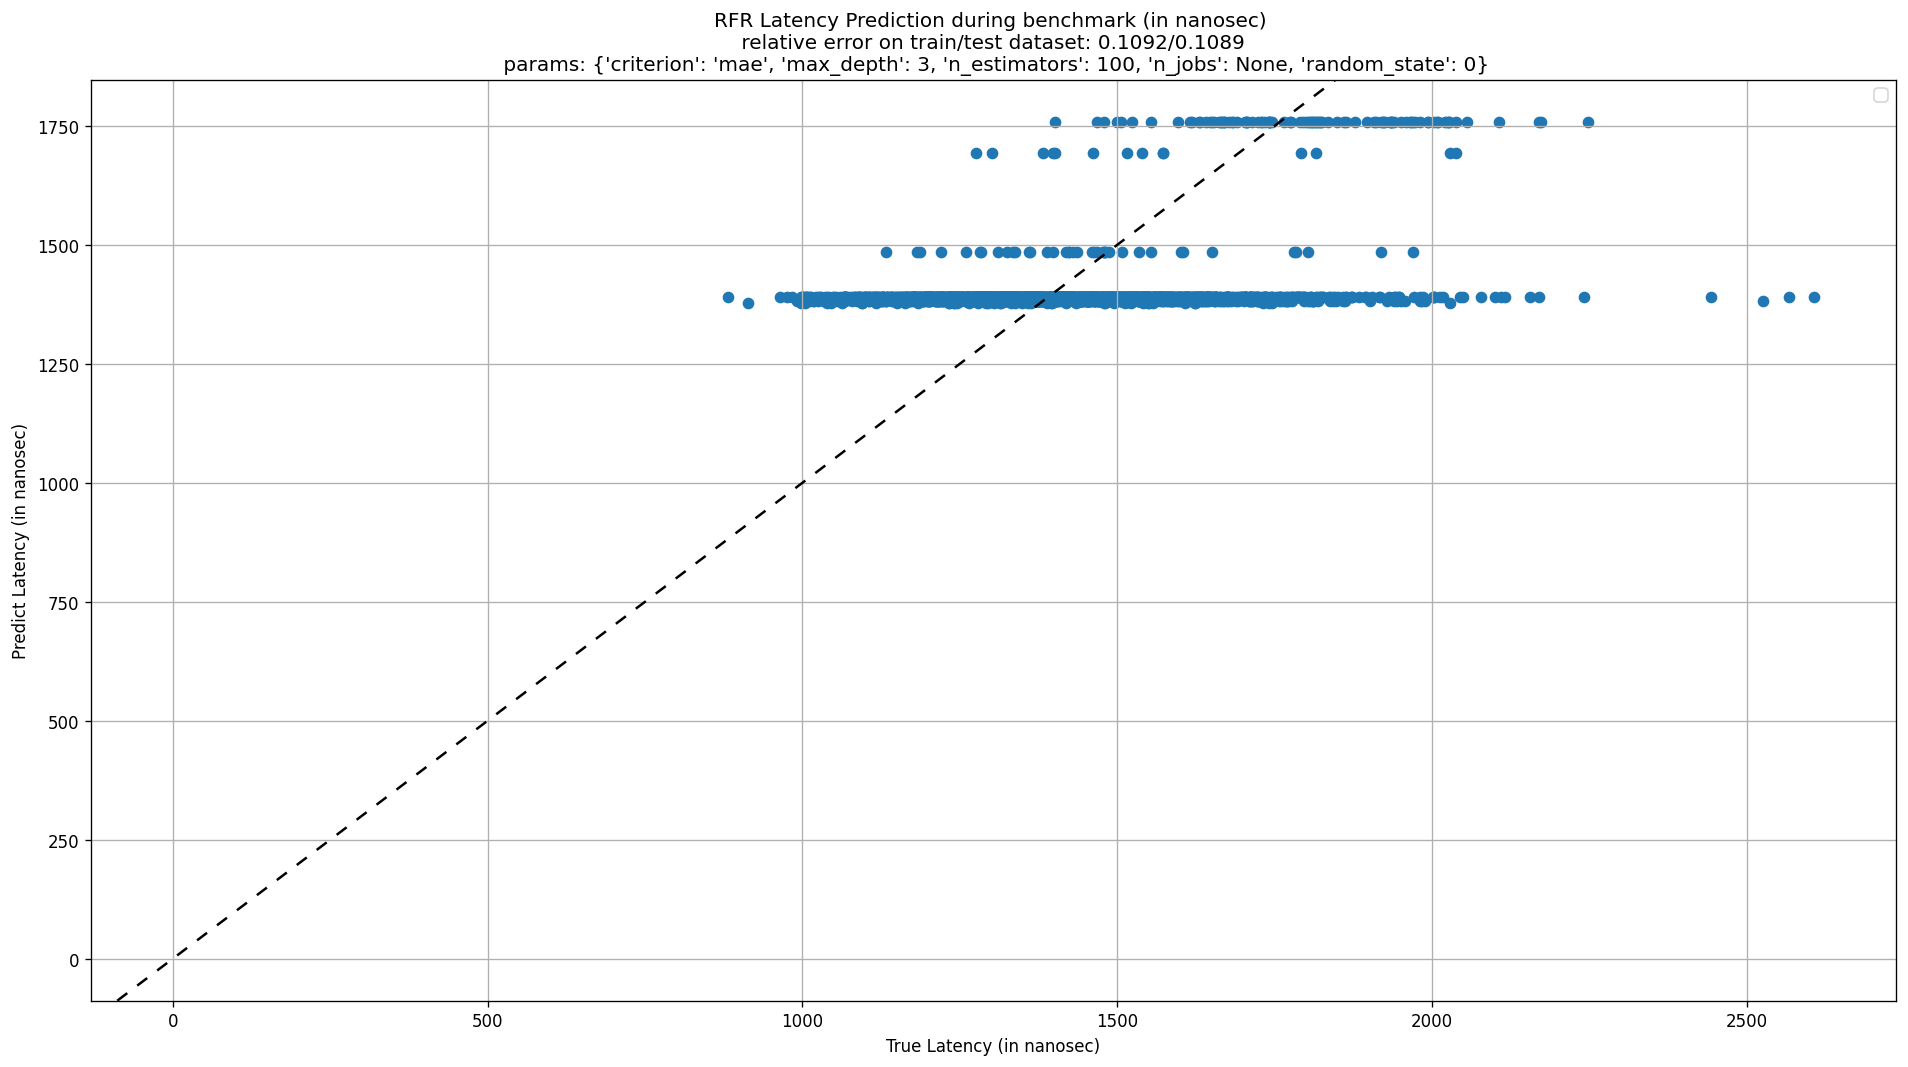

Warm Up Drop Timestamp: 369562672
In microsec, Number of bins: 311, nBins: [ 21.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.
  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.
  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.
  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.
  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178.
 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192.
 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206.
 2

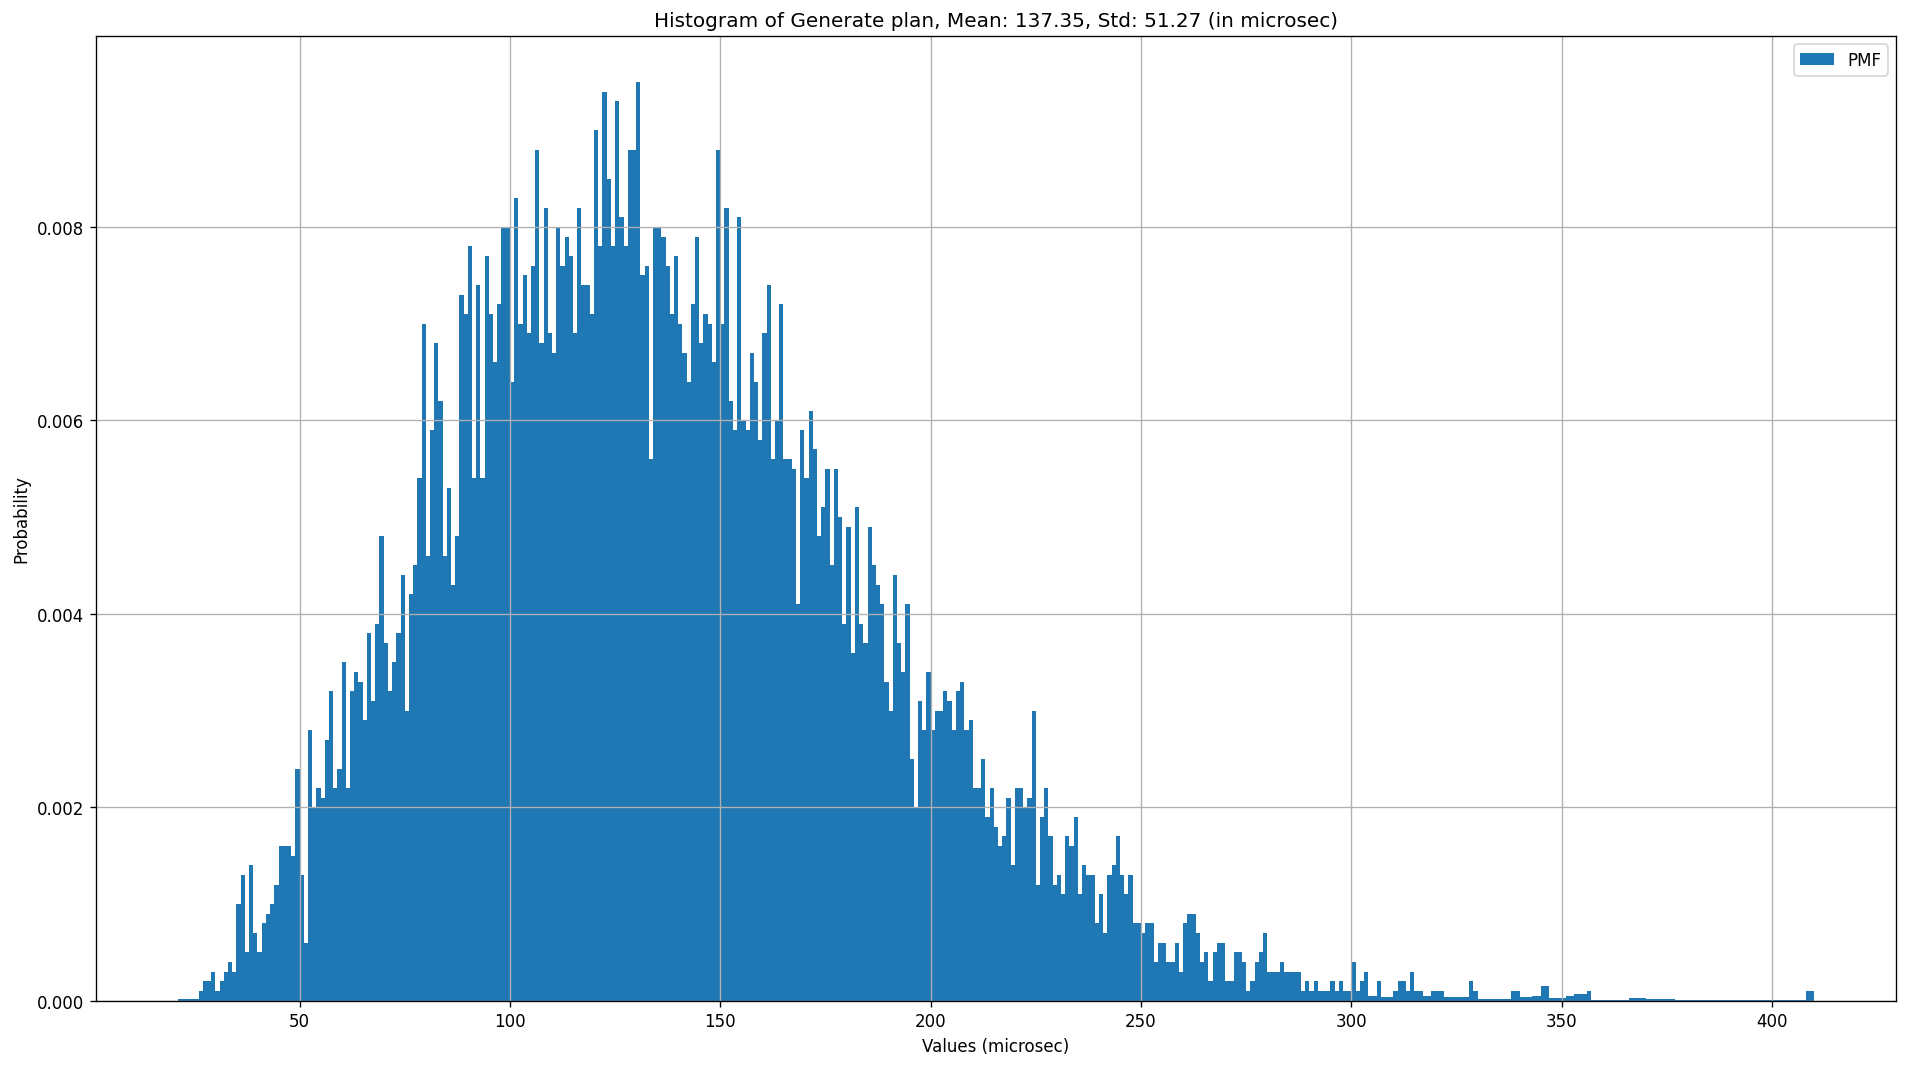

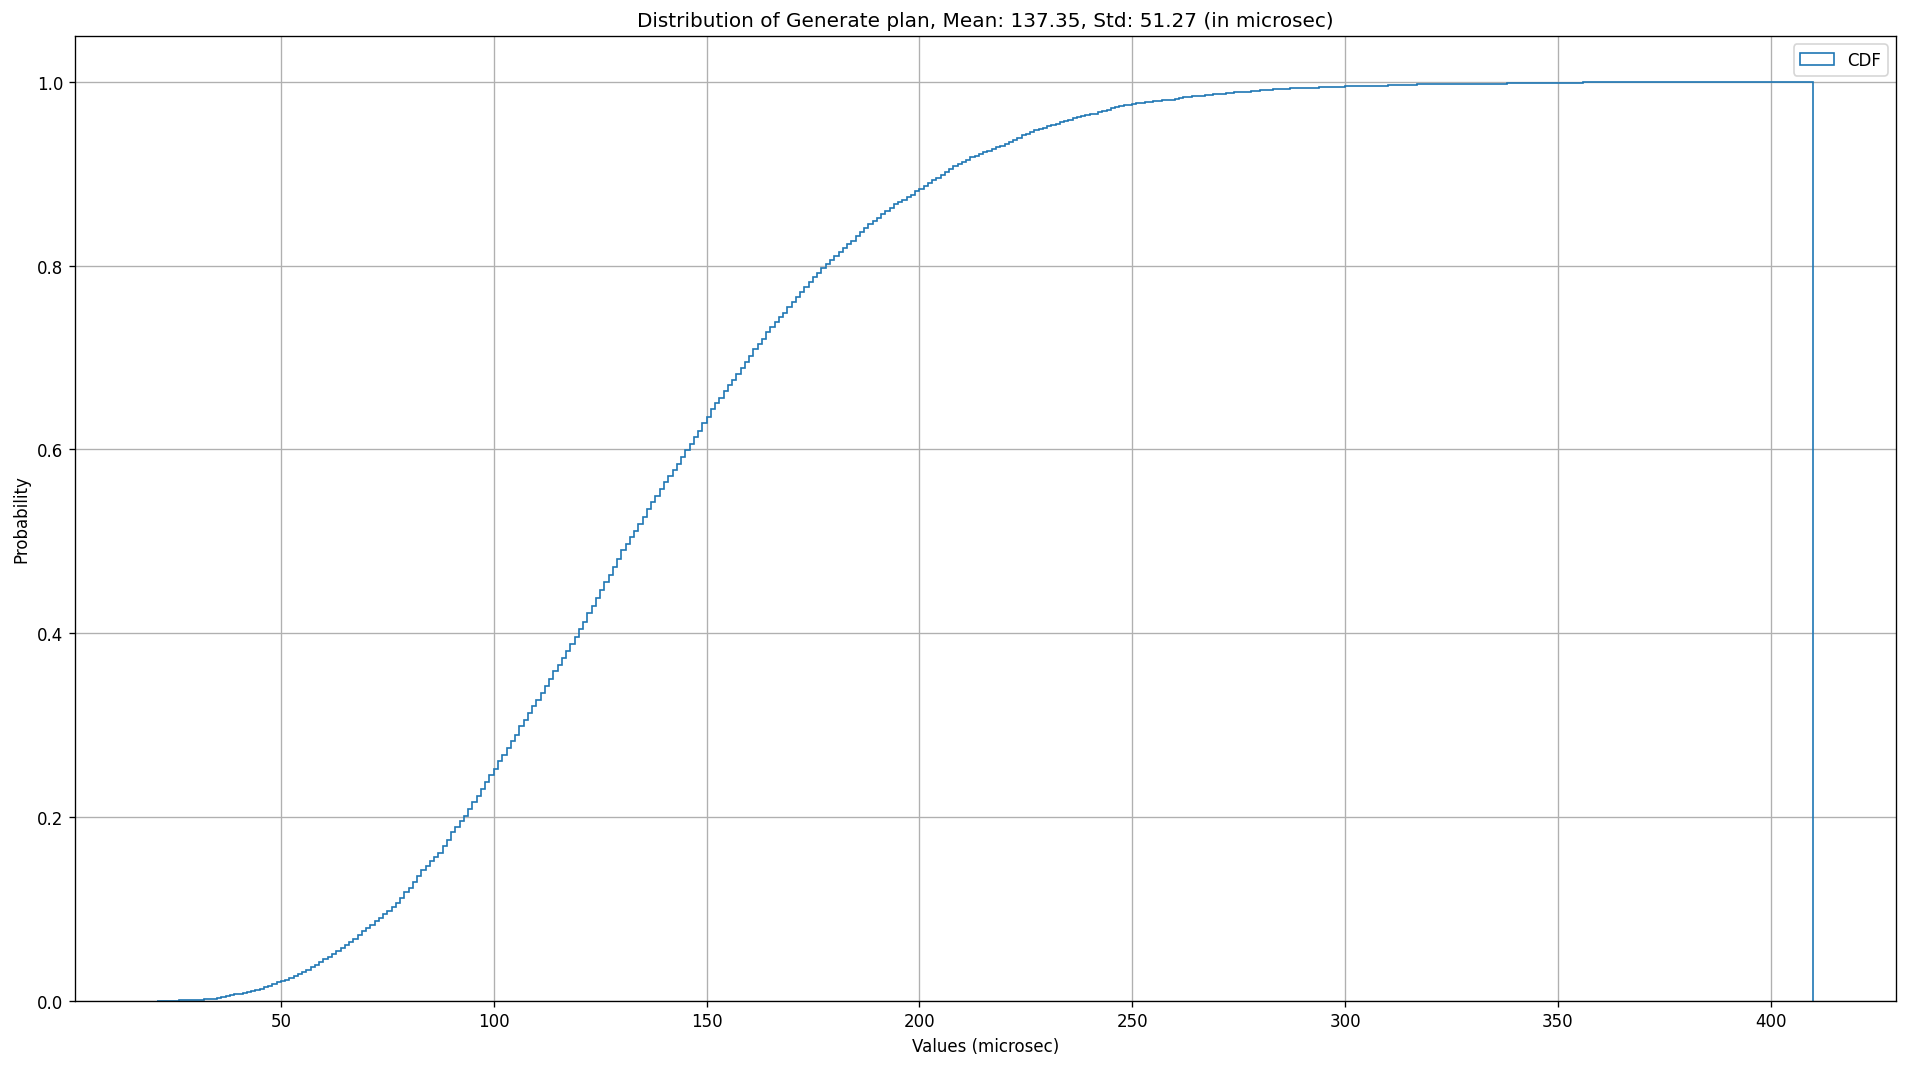

OU - Generate plan Features shape: (10000, 14)


Num of reads  Num of writes  Num of active txs  Thread pool size  \
0               10              0                  1                50   
1               10              0                  1                50   
2               10              0                  1                50   
3               10              0                  1                50   
4               10              0                  1                50   
...            ...            ...                ...               ...   
9995            10              0                  1                50   
9996            10              0                  1                50   
9997            10              0                  1                50   
9998            10              0                  1                50   
9999            10              0                  1                50   

      CPU utilization  Num of cache read  Num of cache insert  \
0                 3.0                 20                    0   
1                 2.0                 20                    0   
2                 2.0                 20                    0   
3                 2.0                 20                    0   
4                 2.0                 20                    0   
...               ...                ...                  ...   
9995              0.0                 20                    0   
9996              4.0                 20                    0   
9997              4.0                 20                    0   
9998              4.0                 20                    0   
9999              0.0                 20                    0   

      Num of cache update  Num of arithmetic operations  Num of write record  \
0                       0                             0                    0   
1                       0                             0                    0   
2                       0                             0                    0   
3                       0                             0                    0   
4                       0                             0                    0   
...                   ...                           ...                  ...   
9995                    0                             0                    0   
9996                    0                             0                    0   
9997                    0                             0                    0   
9998                    0                             0                    0   
9999                    0                             0                    0   

      Num of bytes  Num of read write record  Num of log flush bytes  \
0                0                        10                       0   
1                0                        10                       0   
2                0                        10                       0   
3                0                        10                       0   
4                0                        10                       0   
...            ...                       ...                     ...   
9995             0                        10                       0   
9996             0                        10                       0   
9997             0                        10                       0   
9998             0                        10                       0   
9999             0                        10                       0   

      Num of Threads  
0                 45  
1                 66  
2                 67  
3                 67  
4                 67  
...              ...  
9995              67  
9996              67  
9997              67  
9998              67  
9999              67  

[10000 rows x 14 columns]

OU - Generate plan Targets shape: (10000,)


0       110221
1       103124
2        92526
3       113258
4        96550
         ...  
9995    144748
9996    162841
9997    146063
9998    137321
9999    131170
Name: Generate plan, Length: 10000, dtype: int64

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.3673/0.3582
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


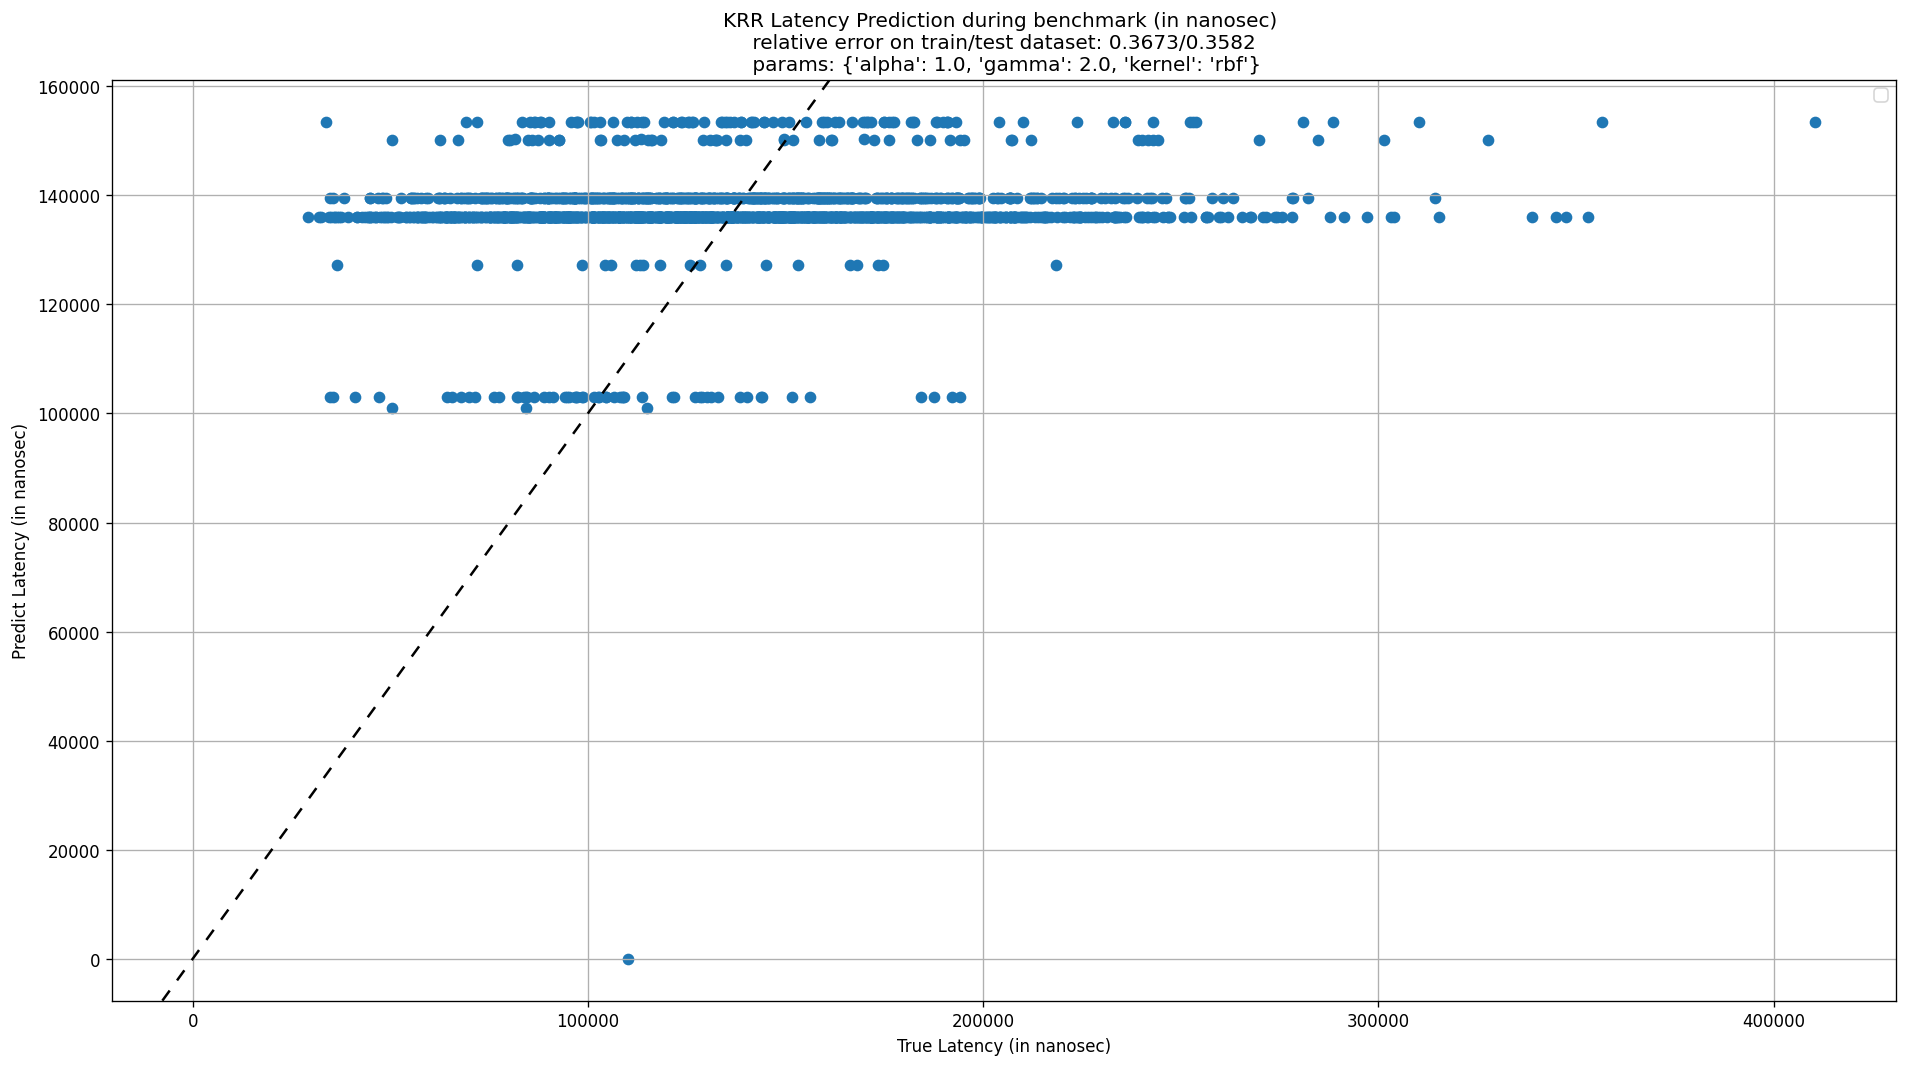

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.35517786 -0.35517974
 -0.35517169 -0.35516218 -0.35517963 -0.35516517 -0.35516292 -0.35517754
 -0.35516987 -0.35517958 -0.35518302 -0.35517562 -0.3551689  -0.35517246
 -0.35516196 -0.35515122]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.3552/0.3477
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


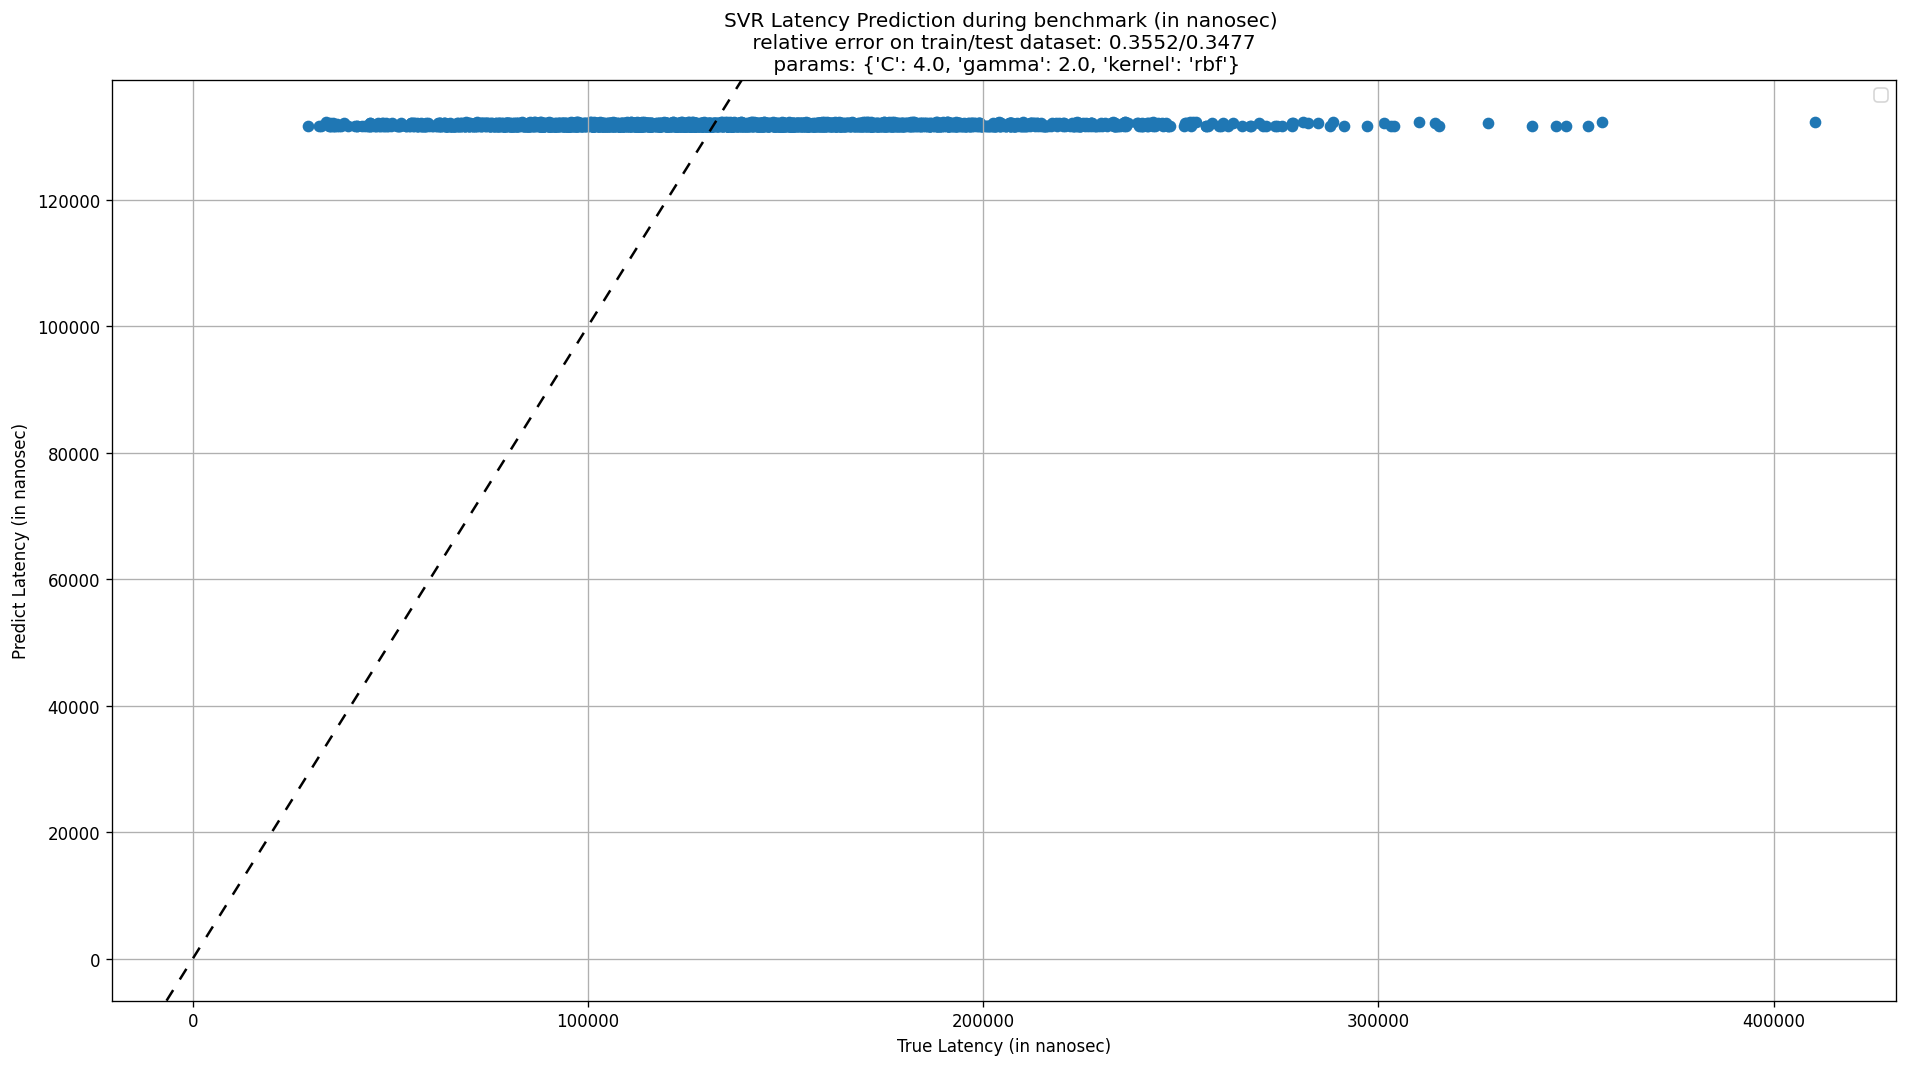

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.3566/0.3491
Best Params: {'alpha': 1, 'epsilon': 1.1}


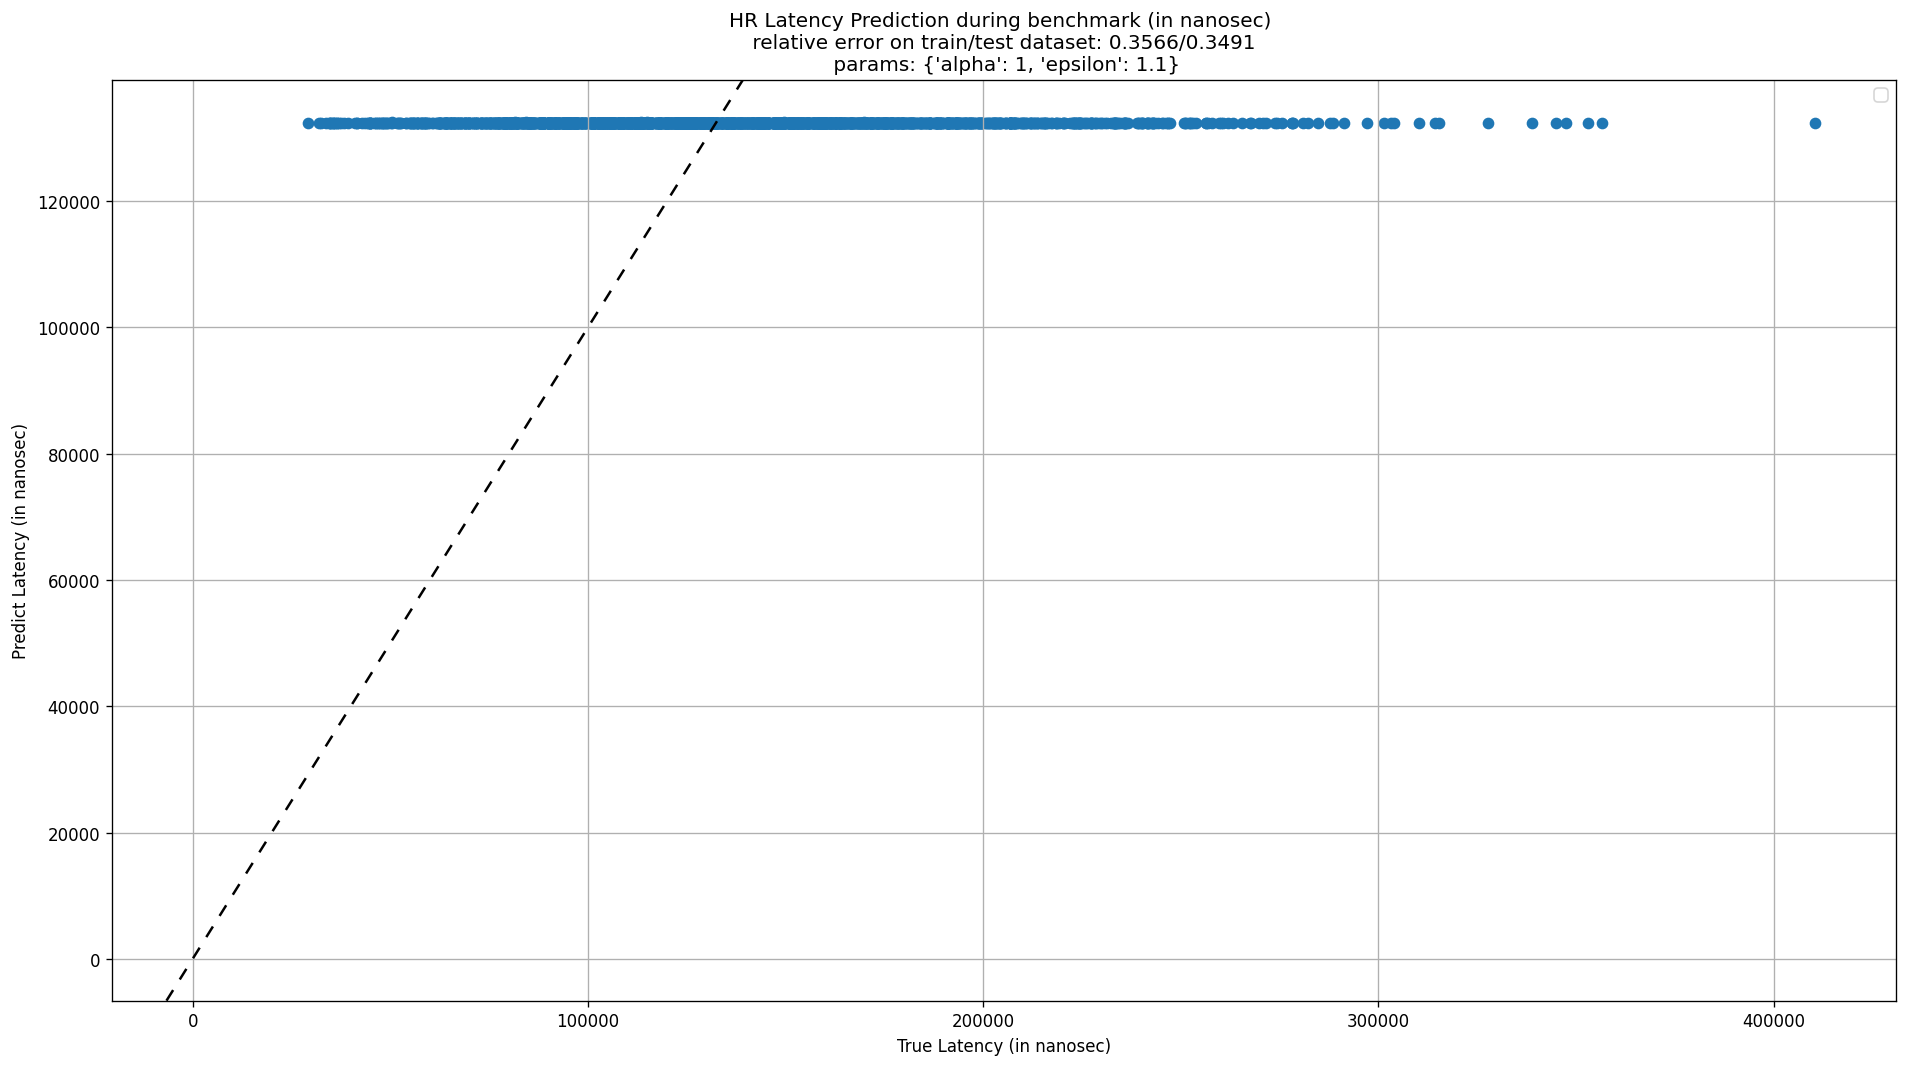

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [ ]:
# for path in paths:
#     rt.setPath(path=path)
#     rt.buildDataset()
#     for targetName in targetNames:
#         rt.fit(featureNames=featureNames, targetName=targetName, n_jobs=n_jobs)